# Import Libraries

In [1]:
import random
from datetime import datetime, timedelta
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
#import community as community_louvain

# Load Space-Track Dynamic Graph

## Load nodes data

In [2]:
def get_nodes_dataframe(dataset_path, reduced=False, frac1=0.25, reduced_sample_alt_e=False, frac2=1.0, min_alt=500,
                        max_alt=520,
                        e_thres=0.25, sampled1=False, reduced_sample_leos=True, frac3=0.25, leo='leo4', sampled2=True):
    # Determine the file path based on conditions
    if reduced:
        nodes_savepath = f"{dataset_path}datasets/space-track-ap2-graph-node-feats-reduced-{int(frac1 * 100)}.csv"
    elif reduced_sample_alt_e:
        if sampled1:
            nodes_savepath = f"{dataset_path}datasets/space-track-ap2-graph-node-feats-reduced-{int(frac2 * 100)}-h-{min_alt}-{max_alt}-e-{int(e_thres * 100)}.csv"
        else:
            nodes_savepath = f"{dataset_path}datasets/space-track-ap2-graph-node-feats-reduced-h-{min_alt}-{max_alt}-e-{int(e_thres * 100)}.csv"
    elif reduced_sample_leos:
        if sampled2:
            nodes_savepath = f"{dataset_path}datasets/space-track-ap2-graph-node-feats-{leo}-reduced-{int(frac3 * 100)}.csv"
        else:
            nodes_savepath = f"{dataset_path}datasets/space-track-ap2-graph-node-feats-{leo}.csv"
    else:
        nodes_savepath = f'{dataset_path}datasets/space-track-ap2-graph-node-feats.csv'

    # Read the CSV file and clean the data
    nodes_df = pd.read_csv(nodes_savepath, memory_map=True,
                           usecols=['NORAD_CAT_ID', 'MEAN_MOTION', 'ECCENTRICITY', 'INCLINATION', 'RA_OF_ASC_NODE',
                                    'ARG_OF_PERICENTER', 'MEAN_ANOMALY', 'REV_AT_EPOCH', 'BSTAR', 'MEAN_MOTION_DOT',
                                    'SEMIMAJOR_AXIS', 'PERIOD', 'APOAPSIS', 'PERIAPSIS',
                                    'OBJECT_TYPE', 'RCS_SIZE', 'CONSTELLATION_DISCOS_ID', 'PX', 'PY', 'PZ',
                                    'VX', 'VY', 'VZ', 'TIMESTAMP']).set_index('NORAD_CAT_ID').fillna(
        {'CONSTELLATION_DISCOS_ID': 0})

    print(f"Space-Track AP2 graph node features loaded from: {nodes_savepath}")

    nodes_df[['EPOCH_DATE', 'EPOCH_TIME']] = nodes_df['TIMESTAMP'].str.split(' ', expand=True)
    nodes_df['CONSTELLATION_DISCOS_ID'] = nodes_df['CONSTELLATION_DISCOS_ID'].astype(int)
    # Return the dataframe
    return nodes_df, nodes_savepath


nodes_df, nodes_savepath = get_nodes_dataframe(dataset_path='../')
nodes_df.head()

Space-Track AP2 graph node features loaded from: ../datasets/space-track-ap2-graph-node-feats-leo4-reduced-25.csv


MEAN_MOTION  ECCENTRICITY  INCLINATION  RA_OF_ASC_NODE  \
NORAD_CAT_ID                                                           
53              12.173182      0.009849      47.2749      245.136139   
1314            12.917792      0.003186      90.2439      346.489073   
1570            12.527797      0.010160      56.0579       38.416745   
1573            12.410282      0.006615      56.0518      218.083507   
1574            12.370203      0.006564      56.0539      282.997424   

              ARG_OF_PERICENTER  MEAN_ANOMALY  REV_AT_EPOCH     BSTAR  \
NORAD_CAT_ID                                                            
53                   290.259668     93.520449         82552  0.001154   
1314                 121.537524     93.047660         51454  0.000067   
1570                 177.606018    281.664377         66873  0.000116   
1573                 320.617156    261.950267         64321  0.000149   
1574                 126.316083    331.609578         63479  0.000209   

              MEAN_MOTION_DOT  SEMIMAJOR_AXIS  ...  CONSTELLATION_DISCOS_ID  \
NORAD_CAT_ID                                   ...                            
53               2.917841e-11     7986.303654  ...                        0   
1314             2.298905e-11     7672.648410  ...                        0   
1570            -6.896714e-11     7825.246832  ...                        0   
1573            -6.366198e-11     7880.854733  ...                        0   
1574            -5.747262e-11     7891.614782  ...                        0   

                       PX           PY           PZ        VX        VY  \
NORAD_CAT_ID                                                              
53            -981.739653 -7532.454068  2463.445980  5.185705  0.803544   
1314         -6109.304395  1487.265525 -4410.214654  4.005457 -0.936573   
1570         -3549.131956  2696.045132  6411.820026 -5.164112 -4.866150   
1573          2808.836400  5941.159037 -4370.626680 -5.568033 -0.634834   
1574          4000.103782  1984.830449  6449.951328 -2.117379  6.781488   

                    VZ            TIMESTAMP  EPOCH_DATE  EPOCH_TIME  
NORAD_CAT_ID                                                         
53            4.730939  2023-12-28 00:00:00  2023-12-28    00:00:00  
1314         -5.909974  2023-12-28 00:00:00  2023-12-28    00:00:00  
1570         -0.897586  2023-12-28 00:00:00  2023-12-28    00:00:00  
1573         -4.361757  2023-12-28 00:00:00  2023-12-28    00:00:00  
1574         -0.799534  2023-12-28 00:00:00  2023-12-28    00:00:00  

[5 rows x 25 columns]

## Load edges data

In [3]:
edges_df = pd.read_csv(nodes_savepath.replace('node-feats', 'edges'), memory_map=True).rename(
    columns={'datetime': 'timestamp'})
edges_df.head()

source  target  weight        r_dist       it_dist      ct_dist  \
0      53    8168       1  4.207451e+06  3.649788e+06  1660.927964   
1   13527   48242       1  6.600881e+06  1.241215e+07  1445.055658   
2   13538   16456       1  3.261385e+05  2.032948e+06  1392.352587   
3   13538   19785       1  1.241162e+06  7.666014e+06  1561.350018   
4   13766   16456       1  4.163467e+04  1.124264e+07   636.122198   

           dist            timestamp  prop  
0  5.569883e+06  2023-12-28 00:00:00  True  
1  1.405820e+07  2023-12-28 00:00:00  True  
2  2.058943e+06  2023-12-28 00:00:00  True  
3  7.765839e+06  2023-12-28 00:00:00  True  
4  1.124272e+07  2023-12-28 00:00:00  True

In [14]:
import pandas as pd

def compute_average_active_time(edges_df):
    """
    Computes the average active time of all edges in the graph.
    An active time of an edge corresponds to the maximum number of consecutive timestamps
    the edge appears throughout the dataset.
    
    :param edges_df: A pandas DataFrame with columns ['source', 'target', 'timestamp'].
    :return: The average active time of all edges.
    """
    # Convert timestamp column to datetime
    edges_df['timestamp'] = pd.to_datetime(edges_df['timestamp'])
    
    # Sort values by edge and timestamp
    edges_df = edges_df.sort_values(by=['source', 'target', 'timestamp'])
    
    # Group by edges
    edge_groups = edges_df.groupby(['source', 'target'])['timestamp'].apply(list)
    
    active_times = []
    
    for timestamps in edge_groups:
        timestamps = sorted(timestamps)  # Ensure timestamps are sorted
        max_consecutive = 1
        current_consecutive = 1
        
        for i in range(1, len(timestamps)):
            # Compute time difference in hours (assuming hourly intervals)
            time_diff = (timestamps[i] - timestamps[i-1]).total_seconds() / 3600
            
            if time_diff == 1:  # Consecutive timestamp
                current_consecutive += 1
            else:
                max_consecutive = max(max_consecutive, current_consecutive)
                current_consecutive = 1  # Reset count
        
        # Update max consecutive appearances
        max_consecutive = max(max_consecutive, current_consecutive)
        active_times.append(max_consecutive)
    
    # Compute average active time
    return sum(active_times) / float(len(active_times)) if active_times else 0

avg_active_time = compute_average_active_time(edges_df)
print(f"Average active time of edges: {avg_active_time:.2f} hours")

109988 109592
Average active time of edges: 1.00 hours


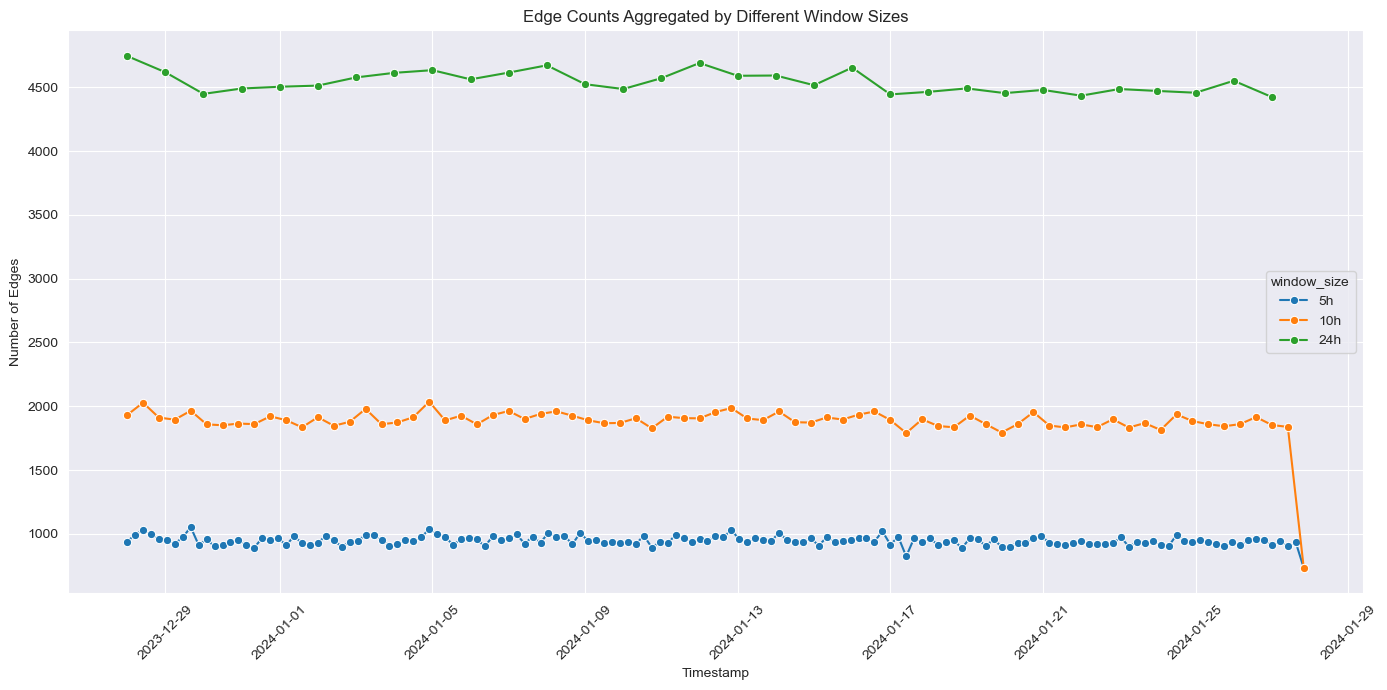

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_edge_counts_by_windows(edges_df, window_sizes=['1min', '5min', '15min']):
    """e
    - edges_df: pandas DataFrame with columns ['source', 'target', 'timestamp'].
      The 'timestamp' column should be convertible to datetime.
    - window_sizes: list of strings representing pandas offset aliases (e.g., '1min', '5min', etc.).
    
    The function creates a line plot for each window size, making it easier to decide
    which window size yields a reasonable balance between noise and smoothing for your
    time-series model.
    """
    # Ensure the timestamp column is in datetime format
    edges_df['timestamp'] = pd.to_datetime(edges_df['timestamp'])
    
    # List to store the aggregated dataframes for each window size
    agg_dfs = []
    for window in window_sizes:
        # Resample based on the window size and count the number of edges in each window
        df_window = (edges_df
                     .set_index('timestamp')
                     .resample(window)
                     .size()
                     .reset_index(name='edge_count'))
        # Add a column to identify the window size used
        df_window['window_size'] = window
        agg_dfs.append(df_window)
    
    # Combine all the aggregated data into one dataframe for plotting
    agg_df = pd.concat(agg_dfs)
    
    # Create the line plot using seaborn
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=agg_df, x='timestamp', y='edge_count', hue='window_size', marker="o")
    plt.title('Edge Counts Aggregated by Different Window Sizes')
    plt.xlabel('Timestamp')
    plt.ylabel('Number of Edges')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_edge_counts_by_windows(edges_df, window_sizes=['5h', '10h', '24h'])

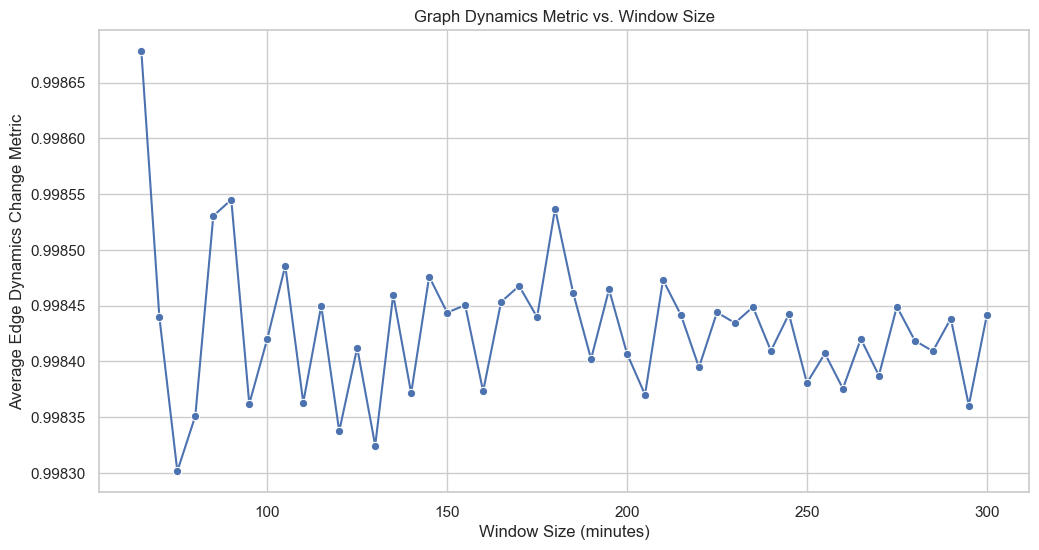

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_graph_dynamics(edges_df, nodes_df):
    # Ensure the timestamp columns are in datetime format.
    edges_df['timestamp'] = pd.to_datetime(edges_df['timestamp'])
    nodes_df['TIMESTAMP'] = pd.to_datetime(nodes_df['TIMESTAMP'])
    
    # Sort the edges by time
    edges_df = edges_df.sort_values('timestamp')
    
    # Determine the overall time range
    start_time = edges_df['timestamp'].min()
    end_time = edges_df['timestamp'].max()
    
    # Define window sizes in minutes from 5 to 300 (inclusive) with 5 minute steps
    window_sizes = np.arange(5, 305, 5)
    metric_values = []
    
    # Loop over each window size
    for w in window_sizes:
        window_metric_list = []
        current_start = start_time
        
        # Divide the overall time range into non-overlapping windows of size w minutes.
        while current_start < end_time:
            current_end = current_start + pd.Timedelta(minutes=w)
            # Filter the edges for this window
            window_edges = edges_df[(edges_df['timestamp'] >= current_start) & (edges_df['timestamp'] < current_end)]
            if window_edges.empty:
                current_start = current_end
                continue
            
            # Get the sorted unique timestamps in this window
            times_in_window = sorted(window_edges['timestamp'].unique())
            
            # If there's not enough data (at least 2 timestamps), skip this window.
            if len(times_in_window) < 2:
                current_start = current_end
                continue
            
            pair_metrics = []
            # Compute the metric for each consecutive pair of timestamps
            for i in range(len(times_in_window) - 1):
                t1, t2 = times_in_window[i], times_in_window[i+1]
                # Get the sets of edges at these two timestamps.
                edges_t1 = set(window_edges[window_edges['timestamp'] == t1][['source', 'target']].apply(tuple, axis=1))
                edges_t2 = set(window_edges[window_edges['timestamp'] == t2][['source', 'target']].apply(tuple, axis=1))
                
                # Compute the symmetric difference and union.
                union_edges = edges_t1.union(edges_t2)
                if len(union_edges) == 0:
                    diff_ratio = 0
                else:
                    diff_edges = edges_t1.symmetric_difference(edges_t2)
                    diff_ratio = len(diff_edges) / len(union_edges)
                pair_metrics.append(diff_ratio)
            
            # Average the metric for this window if we computed any pair metrics.
            if pair_metrics:
                window_metric_list.append(np.mean(pair_metrics))
            
            # Move to the next window.
            current_start = current_end
        
        # Average the metric over all windows for this window size.
        if window_metric_list:
            metric_values.append(np.mean(window_metric_list))
        else:
            metric_values.append(np.nan)
    
    # Create the plot using seaborn.
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(x=window_sizes, y=metric_values, marker="o")
    ax.set_xlabel("Window Size (minutes)")
    ax.set_ylabel("Average Edge Dynamics Change Metric")
    ax.set_title("Graph Dynamics Metric vs. Window Size")
    plt.show()

plot_graph_dynamics(edges_df, nodes_df)

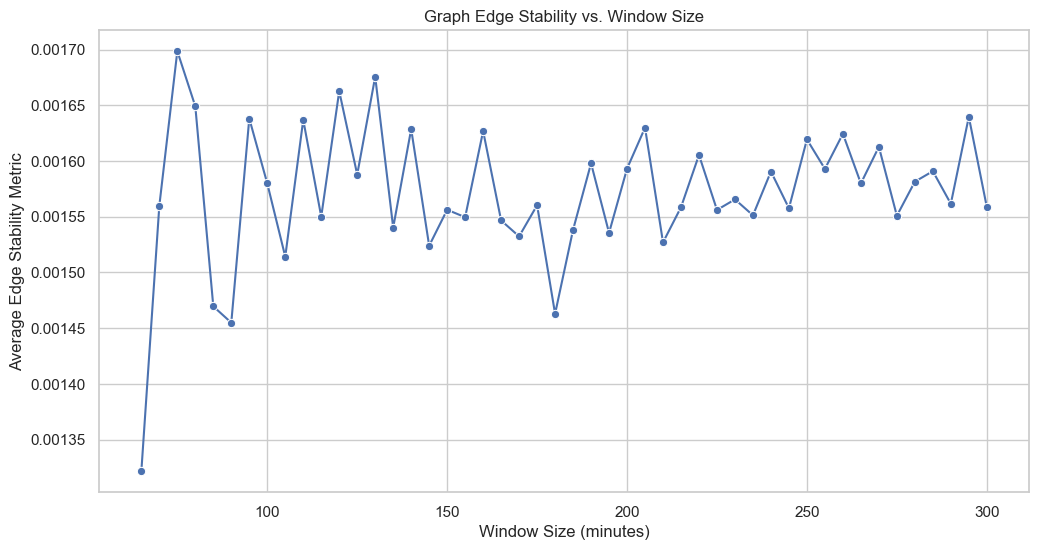

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_graph_stability(edges_df, nodes_df):
    # Convert timestamp columns to datetime objects.
    edges_df['timestamp'] = pd.to_datetime(edges_df['timestamp'])
    nodes_df['TIMESTAMP'] = pd.to_datetime(nodes_df['TIMESTAMP'])
    
    # Sort the edges by time.
    edges_df = edges_df.sort_values('timestamp')
    
    # Determine the overall time range.
    start_time = edges_df['timestamp'].min()
    end_time = edges_df['timestamp'].max()
    
    # Define window sizes in minutes from 5 to 300 (inclusive) with 5 minute steps.
    window_sizes = np.arange(5, 305, 5)
    metric_values = []
    
    # Loop over each window size.
    for w in window_sizes:
        window_metric_list = []
        current_start = start_time
        
        # Divide the overall time range into non-overlapping windows of size w minutes.
        while current_start < end_time:
            current_end = current_start + pd.Timedelta(minutes=w)
            # Filter the edges for this window.
            window_edges = edges_df[(edges_df['timestamp'] >= current_start) & (edges_df['timestamp'] < current_end)]
            if window_edges.empty:
                current_start = current_end
                continue
            
            # Get the sorted unique timestamps in this window.
            times_in_window = sorted(window_edges['timestamp'].unique())
            
            # Need at least 2 timestamps to compare.
            if len(times_in_window) < 2:
                current_start = current_end
                continue
            
            pair_metrics = []
            # Compute the stability metric for each consecutive pair of timestamps.
            for i in range(len(times_in_window) - 1):
                t1, t2 = times_in_window[i], times_in_window[i+1]
                # Create sets of edges for t1 and t2.
                edges_t1 = set(window_edges[window_edges['timestamp'] == t1][['source', 'target']].apply(tuple, axis=1))
                edges_t2 = set(window_edges[window_edges['timestamp'] == t2][['source', 'target']].apply(tuple, axis=1))
                
                union_edges = edges_t1.union(edges_t2)
                if len(union_edges) == 0:
                    stability = 0
                else:
                    intersection_edges = edges_t1.intersection(edges_t2)
                    stability = len(intersection_edges) / len(union_edges)
                pair_metrics.append(stability)
            
            # Average the metric for this window if we computed any pair metrics.
            if pair_metrics:
                window_metric_list.append(np.mean(pair_metrics))
            
            # Move to the next window.
            current_start = current_end
        
        # Average the metric over all windows for this window size.
        if window_metric_list:
            metric_values.append(np.mean(window_metric_list))
        else:
            metric_values.append(np.nan)
    
    # Plot the metric using seaborn.
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(x=window_sizes, y=metric_values, marker="o")
    ax.set_xlabel("Window Size (minutes)")
    ax.set_ylabel("Average Edge Stability Metric")
    ax.set_title("Graph Edge Stability vs. Window Size")
    plt.show()

plot_graph_stability(edges_df, nodes_df)

## Summary of satellite graph

In [4]:
def print_graph_statistics(edges_df):
    datetime_grouped_edges_df = edges_df.groupby('timestamp')
    summary = datetime_grouped_edges_df.agg(
        num_edges=('source', 'size'),
        num_unique_src=('source', 'nunique'),
        num_unique_tgt=('target', 'nunique')
    )

    summary['num_nodes'] = datetime_grouped_edges_df.apply(
        lambda x: len(set(x['source']) | set(x['target'])),
        include_groups=False
    )

    summary['graph_density'] = datetime_grouped_edges_df.apply(
        lambda x: len(x) / (len(set(x['source']) | set(x['target'])) * (len(set(x['source']) | set(x['target'])) - 1))
        if len(set(x['source']) | set(x['target'])) > 1 else 0,
        include_groups=False
    )

    # Compute statistics
    stats = summary[['num_edges', 'num_nodes', 'graph_density']].agg(['max', 'min', 'mean', 'std'])

    # Print statistics with phrases
    print('Graph Statistics:')
    print('#' * 50)
    print(f"Maximum number of edges: {stats.loc['max', 'num_edges']}")
    print(f"Minimum number of edges: {stats.loc['min', 'num_edges']}")
    print(f"Mean number of edges: {stats.loc['mean', 'num_edges']:.2f}")
    print(f"Standard deviation of edges: {stats.loc['std', 'num_edges']:.2f}")
    print('#' * 50)
    print(f"Maximum number of nodes: {stats.loc['max', 'num_nodes']}")
    print(f"Minimum number of nodes: {stats.loc['min', 'num_nodes']}")
    print(f"Mean number of nodes: {stats.loc['mean', 'num_nodes']:.2f}")
    print(f"Standard deviation of nodes: {stats.loc['std', 'num_nodes']:.2f}")
    print('#' * 50)
    print(f"Maximum graph density: {stats.loc['max', 'graph_density']:.5f}")
    print(f"Minimum graph density: {stats.loc['min', 'graph_density']:.5f}")
    print(f"Mean graph density: {stats.loc['mean', 'graph_density']:.5f}")
    print(f"Standard deviation of graph density: {stats.loc['std', 'graph_density']:.5f}")
    
    # --- Compute node degree statistics ---
    # For each timestamp group, compute the degree for each node as the sum of counts in 'source' and 'target'
    def node_degree_stats(group):
        # Compute counts from source and target separately and combine
        src_counts = group['source'].value_counts()
        tgt_counts = group['target'].value_counts()
        # Combine the two count series: nodes that appear in either source or target
        all_nodes = set(group['source']).union(set(group['target']))
        degrees = {node: src_counts.get(node, 0) + tgt_counts.get(node, 0) for node in all_nodes}
        degree_values = list(degrees.values())
        return pd.Series({
            'max_degree': max(degree_values),
            'min_degree': min(degree_values),
            'mean_degree': np.mean(degree_values),
            'std_degree': np.std(degree_values, ddof=1) if len(degree_values) > 1 else 0
        })
    
    # Apply the node degree function on each timestamp group
    degree_summary = datetime_grouped_edges_df.apply(node_degree_stats, include_groups=False)
    
    # Aggregate the node degree stats across timestamps
    degree_stats = degree_summary.agg(['max', 'min', 'mean', 'std'])
    
    # Print node degree statistics
    print('#' * 50)
    print(f"Maximum node degree (across groups' max_degree): {degree_stats.loc['max', 'max_degree']}")
    print(f"Minimum node degree (across groups' min_degree): {degree_stats.loc['min', 'min_degree']}")
    print(f"Mean of average node degree (mean of mean_degree): {degree_stats.loc['mean', 'mean_degree']:.2f}")
    print(f"Standard deviation of average node degree (std of mean_degree): {degree_stats.loc['std', 'mean_degree']:.2f}")

print_graph_statistics(edges_df)

Graph Statistics:
##################################################
Maximum number of edges: 234.0
Minimum number of edges: 151.0
Mean number of edges: 189.25
Standard deviation of edges: 13.92
##################################################
Maximum number of nodes: 350.0
Minimum number of nodes: 246.0
Mean number of nodes: 298.69
Standard deviation of nodes: 18.16
##################################################
Maximum graph density: 0.00255
Minimum graph density: 0.00176
Mean graph density: 0.00213
Standard deviation of graph density: 0.00013
##################################################
Node Degree Statistics:
##################################################
Maximum node degree (across groups' max_degree): 7.0
Minimum node degree (across groups' min_degree): 1.0
Mean of average node degree (mean of mean_degree): 1.27
Standard deviation of average node degree (std of mean_degree): 0.04


# Exploratory Data Analysis

In [21]:
orbital_units = {
    "MEAN_MOTION": "rev/day",
    "ECCENTRICITY": "",
    "INCLINATION": "degrees",
    "RA_OF_ASC_NODE": "degrees",
    "ARG_OF_PERICENTER": "degrees",
    "MEAN_ANOMALY": "degrees",
    "BSTAR": "earth radii^-1",
    "MEAN_MOTION_DOT": "rev/day^2",
    "MEAN_MOTION_DDOT": "rev/day^3",
    "SEMIMAJOR_AXIS": "km",
    "PERIOD": "minutes",
    "APOAPSIS": "km",
    "PERIAPSIS": "km",
    "PX": "km",
    "PY": "km",
    "PZ": "km",
    "VX": "km/s",
    "VY": "km/s",
    "VZ": "km/s"
}

In [23]:
numerical_columns = nodes_df.select_dtypes(include='float').columns
categorical_columns = nodes_df.select_dtypes(include=['object', 'int']).columns.drop(
    ['REV_AT_EPOCH', 'TIMESTAMP', 'EPOCH_DATE', 'EPOCH_TIME'])
log_scale_columns = ['ECCENTRICITY', 'BSTAR', 'MEAN_MOTION_DOT']

In [ ]:
# Plotting Configuration
sns.set(style="whitegrid")

In [26]:
nodes_df['TIMESTAMP'].unique()

array(['2023-12-28 00:00:00', '2023-12-28 01:00:00',
       '2023-12-28 02:00:00', '2023-12-28 03:00:00',
       '2023-12-28 04:00:00', '2023-12-28 05:00:00',
       '2023-12-28 06:00:00', '2023-12-28 07:00:00',
       '2023-12-28 08:00:00', '2023-12-28 09:00:00',
       '2023-12-28 10:00:00', '2023-12-28 11:00:00',
       '2023-12-28 12:00:00', '2023-12-28 13:00:00',
       '2023-12-28 14:00:00', '2023-12-28 15:00:00',
       '2023-12-28 16:00:00', '2023-12-28 17:00:00',
       '2023-12-28 18:00:00', '2023-12-28 19:00:00',
       '2023-12-28 20:00:00', '2023-12-28 21:00:00',
       '2023-12-28 22:00:00', '2023-12-28 23:00:00',
       '2023-12-29 00:00:00', '2023-12-29 01:00:00',
       '2023-12-29 02:00:00', '2023-12-29 03:00:00',
       '2023-12-29 04:00:00', '2023-12-29 05:00:00',
       '2023-12-29 06:00:00', '2023-12-29 07:00:00',
       '2023-12-29 08:00:00', '2023-12-29 09:00:00',
       '2023-12-29 10:00:00', '2023-12-29 11:00:00',
       '2023-12-29 12:00:00', '2023-12-29 13:0

In [ ]:
import pandas as pd
import random

def filter_random_interval(nodes_df, interval_type='30min'):
    """
    Filters a DataFrame based on a random time interval and ensures that the interval
    does not exceed the available timestamps.

    Parameters:
        nodes_df (pd.DataFrame): DataFrame containing a 'TIMESTAMP' column.
        interval_type (str): Type of interval to filter by. Options are:
                             - '30min': Random 30-minute interval.
                             - '1h'   : Random 1-hour interval.
                             - 'day'  : All data from a random day.
                             - '3day' : Random 3-day interval.
                             - 'all'  : The entire DataFrame (no filtering).
                             
    Returns:
        pd.DataFrame: A filtered DataFrame based on the selected interval.
    """
    # Ensure the TIMESTAMP column is in datetime format
    nodes_df['TIMESTAMP'] = pd.to_datetime(nodes_df['TIMESTAMP'])
    
    # Determine the overall time span of the data
    min_time = nodes_df['TIMESTAMP'].min()
    max_time = nodes_df['TIMESTAMP'].max()
    
    if interval_type in ['30min', '1h', '3day']:
        # Define the desired interval based on the interval_type
        if interval_type == '30min':
            desired_interval = pd.Timedelta(minutes=30)
        elif interval_type == '1h':
            desired_interval = pd.Timedelta(hours=1)
        elif interval_type == '3day':
            desired_interval = pd.Timedelta(days=3)
        
        # Ensure that the overall dataset is large enough to accommodate the desired interval
        if max_time - min_time < desired_interval:
            raise ValueError("Dataset time range is smaller than the desired interval.")
        
        # Generate a valid random_start such that random_start + desired_interval is within range
        valid = False
        while not valid:
            random_start = min_time + (max_time - min_time) * random.random()
            end_time = random_start + desired_interval
            if end_time <= max_time:
                valid = True
        
        # Filter the DataFrame based on the valid interval
        filtered_df = nodes_df[(nodes_df['TIMESTAMP'] >= random_start) & (nodes_df['TIMESTAMP'] < end_time)]
        return filtered_df

    elif interval_type == 'day':
        # For a day, pick a random start and then use its date to filter all rows for that day.
        random_start = min_time + (max_time - min_time) * random.random()
        random_date = random_start.date()
        filtered_df = nodes_df[nodes_df['TIMESTAMP'].dt.date == random_date]
        return filtered_df

    elif interval_type == 'all':
        # Return the entire DataFrame (no filtering).
        return nodes_df.copy()
    
    else:
        raise ValueError("Invalid interval_type. Choose from '30min', '1h', 'day', '3day', or 'all'.")



### Distribution of a numeric feature

#### Specific timestamp

In [ ]:
def plot_numcol_histogram(df, column, timestamp, bins=30, unit="", log_scale=False, save_path='../figures/', figsize=(8, 5),
                          save=False, plot_title=True, show=False):
    # Generate a human-friendly title from the column name.
    feature_title = column.replace('_', ' ').title()

    title = f'Distribution of feature {feature_title} for {timestamp}'

    plt.figure(figsize=figsize)
    # Plot the histogram of the specified numeric column.
    sns.histplot(df[column], log_scale=log_scale, bins=bins)

    # If requested, set the plot title.
    if plot_title:
        plt.title(title)
        
    if log_scale:
        feature_title = f'log({feature_title})'

    # Set x-label with unit information if provided.
    xlabel = feature_title if unit == "" else f"{feature_title} ({unit})"
    plt.xlabel(xlabel)
    plt.ylabel('Number of Space Objects')
    plt.tight_layout()

    # Save the figure if required.
    if save:
        filename = save_path + '_'.join(re.split(r'[ :]', title)) + '.pdf'
        plt.savefig(filename, format='pdf')
        
    if show:
        plt.show()
    plt.close()

In [ ]:
def plot_numcol_violinplot(df, column, timestamp, unit="", log_scale=False, save_path='../figures/', figsize=(8, 5),
                          save=False, plot_title=True, show=False):
    # Generate a human-friendly title from the column name.
    feature_title = column.replace('_', ' ').title()

    title = f'Violin Plot of feature {feature_title} for {timestamp}'

    plt.figure(figsize=figsize)
    # Plot the histogram of the specified numeric column.
    sns.violinplot(df[column], log_scale=log_scale)

    # If requested, set the plot title.
    if plot_title:
        plt.title(title.replace('Violin Plot', 'Distribution'))
    if log_scale:
        feature_title = f'log({feature_title})'

    # Set x-label with unit information if provided.
    xlabel = feature_title if unit == "" else f"{feature_title} ({unit})"
    plt.xlabel(xlabel)
    plt.ylabel('Number of Space Objects')
    plt.tight_layout()

    # Save the figure if required.
    if save:
        filename = save_path + '_'.join(re.split(r'[ :]', title)) + '.pdf'
        plt.savefig(filename, format='pdf')
        
    if show:
        plt.show()
    plt.close()

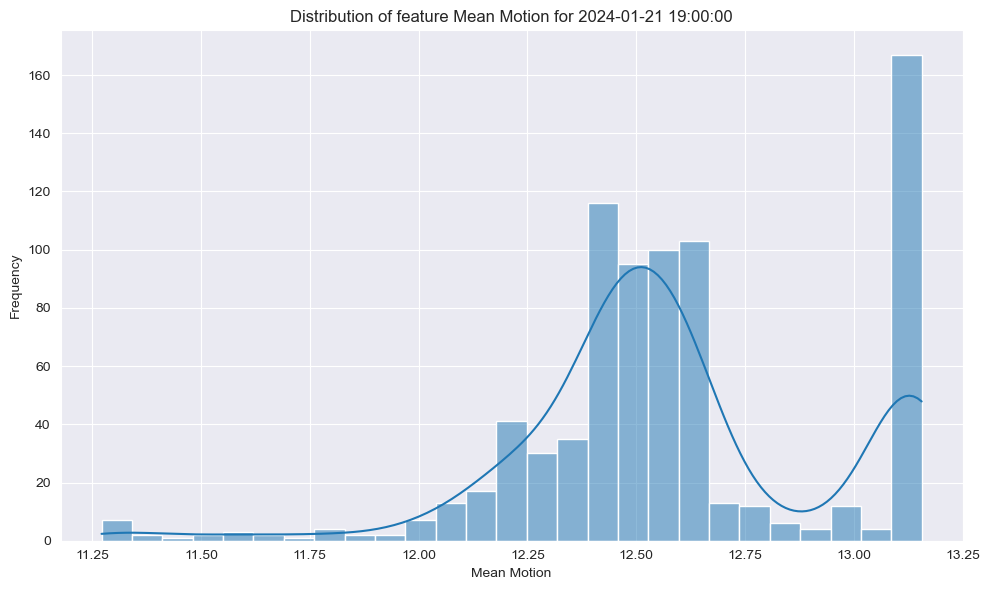

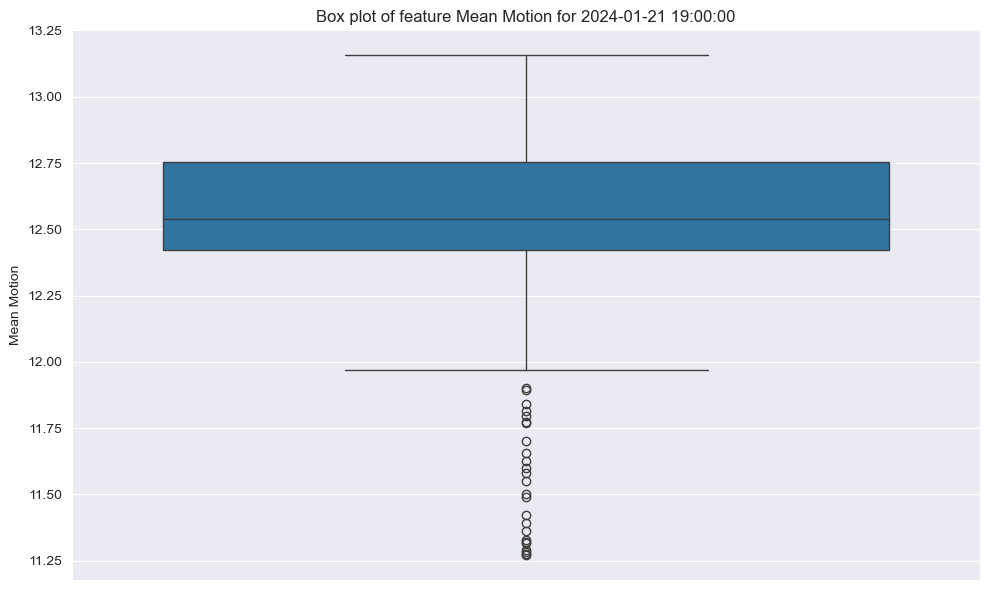

In [19]:
feature = 'MEAN_MOTION'
feature_title = feature.replace('_', ' ').title()
timestamp = nodes_df['TIMESTAMP'].sample(1).values[0]
data = nodes_df[nodes_df['TIMESTAMP'] == timestamp]

plt.figure(figsize=(10, 6))

sns.histplot(nodes_df[column], log_scale=log_scale, bins=bins)

title = f'Distribution of feature {feature_title} for {timestamp}'
plt.title(title)
plt.xlabel(feature_title)
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(re.split(r'[ :]', title)) + '.pdf', format='pdf')
plt.show()

plt.figure(figsize=(10, 6))

sns.boxplot(data, x='TIMESTAMP', y=feature)

title = f'Box plot of feature {feature_title} for {timestamp}'
plt.title(title)
plt.ylabel(feature_title)
plt.xlabel('')
plt.xticks([])
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(re.split(r'[ :]', title)) + '.pdf', format='pdf')
plt.show()

#### Specific day

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


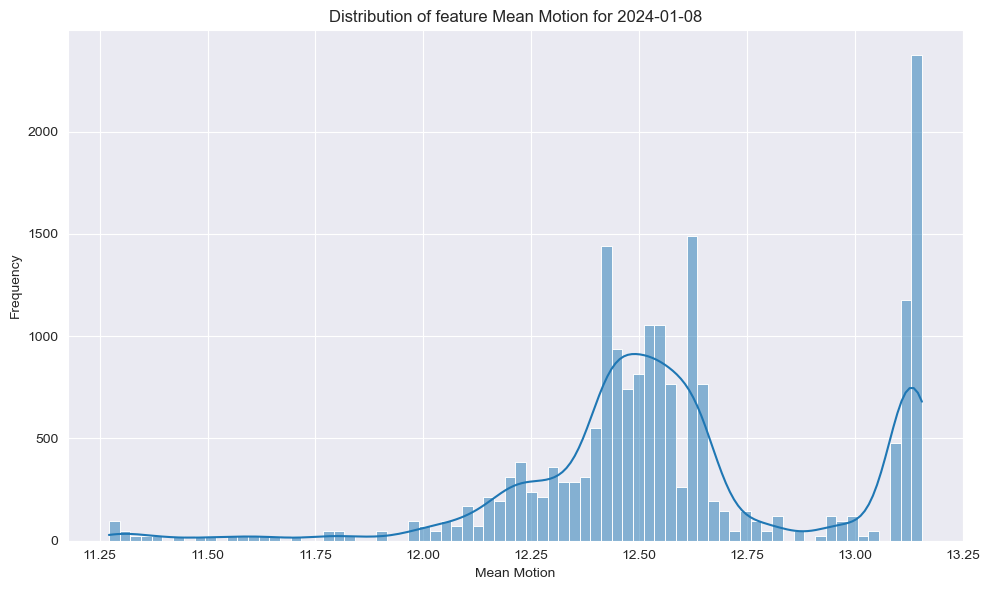

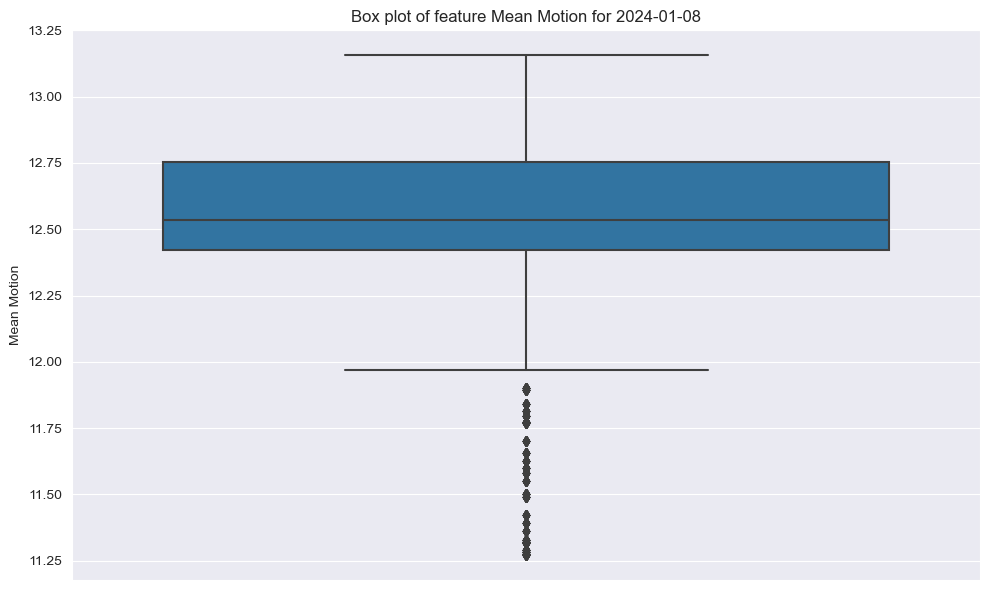

In [28]:
feature = 'MEAN_MOTION'
feature_title = feature.replace('_', ' ').title()
date = (nodes_df['TIMESTAMP'].sample(1).unique()[0]).split()[0]
data = nodes_df[nodes_df['TIMESTAMP'].str[:10] == date]

plt.figure(figsize=(10, 6))

sns.histplot(data[feature], kde=True)

title = f'Distribution of feature {feature_title} for {date}'
#plt.title(title)
plt.xlabel(feature_title)
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data, y=feature)
title = f'Box plot of feature {feature_title} for {date}'
#plt.title(title)
plt.ylabel(feature_title)
plt.xlabel('')
plt.xticks([])
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

#### Whole interval

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


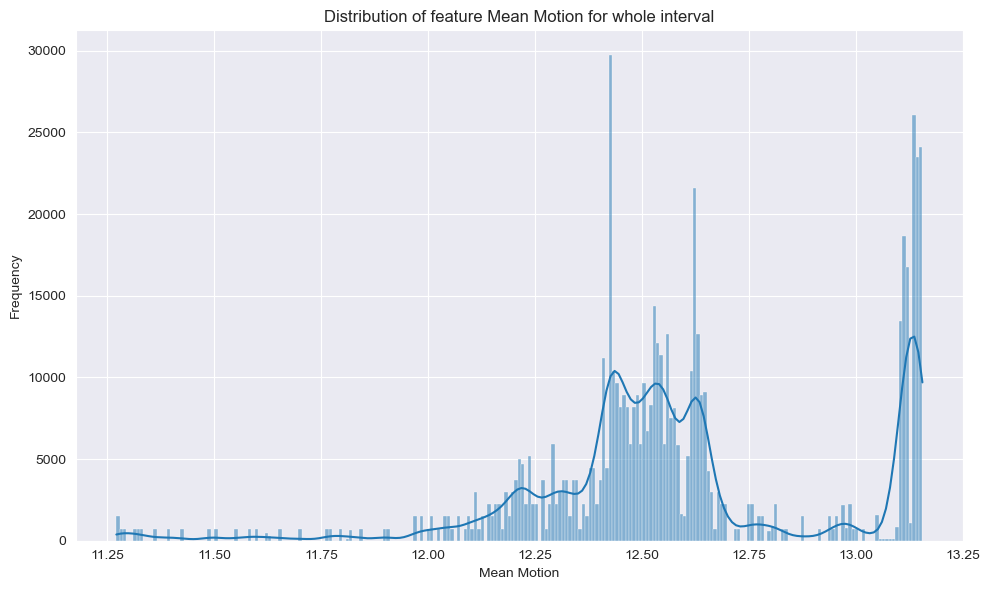

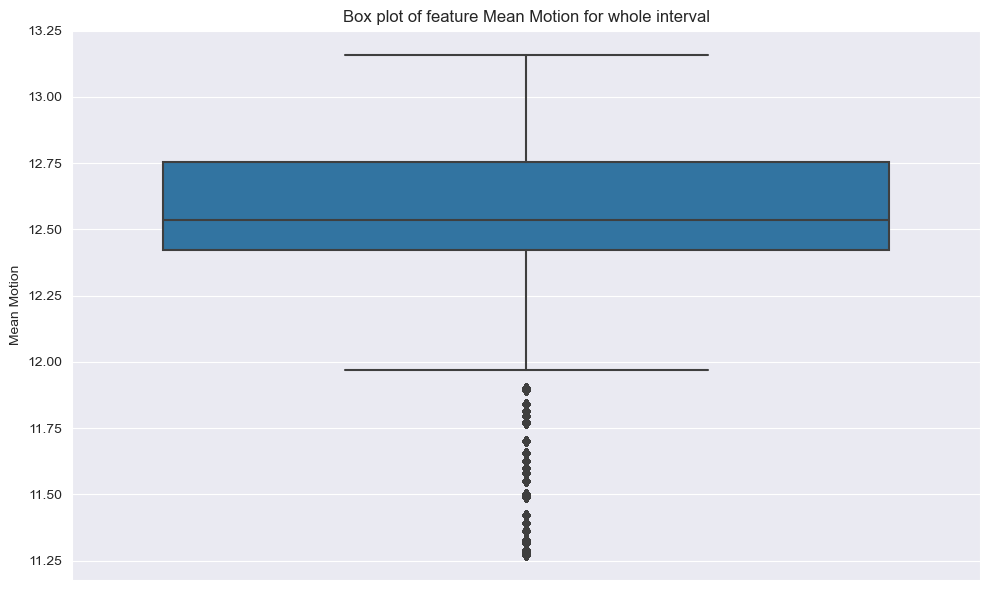

In [30]:
feature = 'MEAN_MOTION'
feature_title = feature.replace('_', ' ').title()
data = nodes_df

plt.figure(figsize=(10, 6))

sns.histplot(data[feature], kde=True)

title = f'Distribution of feature {feature_title} for whole interval'
#plt.title(title)
plt.xlabel(feature_title)
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

plt.figure(figsize=(10, 6))

sns.boxplot(data, y=feature)

title = f'Box plot of feature {feature_title} for whole interval'
#plt.title(title)
plt.ylabel(feature_title)
plt.xlabel('')
plt.xticks([])
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

### Box plot of a numeric feature along a specific day

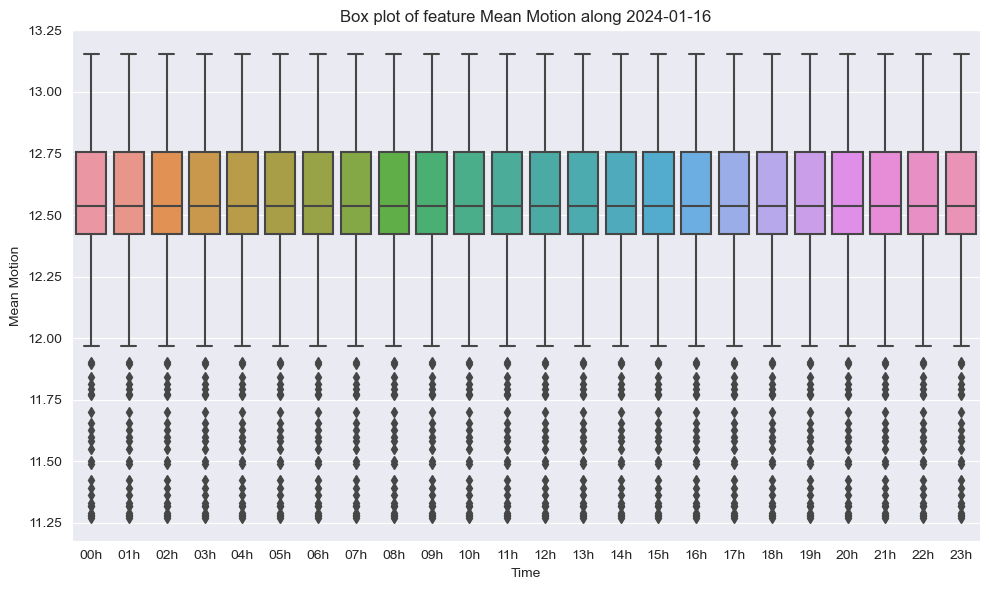

In [40]:
feature = 'MEAN_MOTION'
feature_title = feature.replace('_', ' ').title()
date = (nodes_df['TIMESTAMP'].sample(1).unique()[0]).split()[0]
data = nodes_df[nodes_df['TIMESTAMP'].str[:10] == date]

plt.figure(figsize=(10, 6))
sns.boxplot(data, x='TIMESTAMP', y=feature)
title = f'Box plot of feature {feature_title} along {date}'
#plt.title(title)
plt.ylabel(feature_title)
plt.xlabel('Time')
new_labels = np.char.add(data['TIMESTAMP'].str[11:13].unique().astype(str), 'h')
plt.xticks(ticks=plt.gca().get_xticks(), labels=new_labels)
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

##  Scatter plot of two satellite position coordinates

#### Specific timestamp

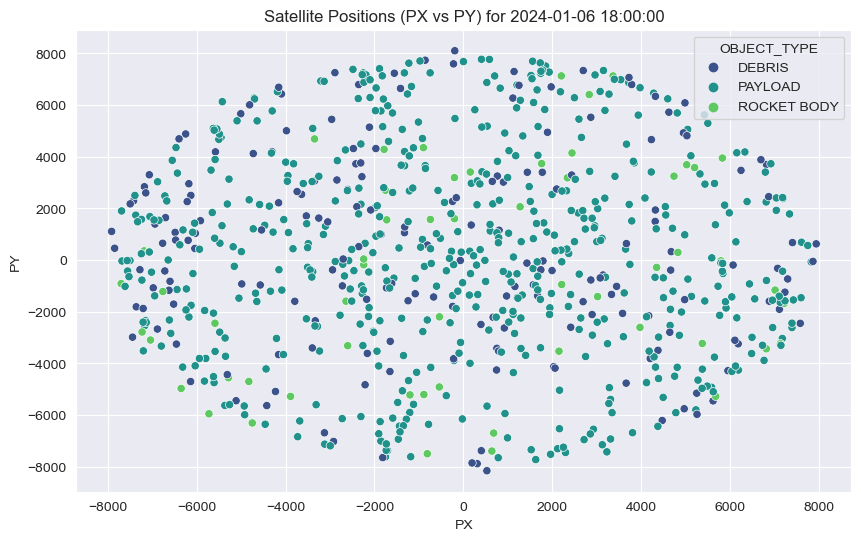

In [15]:
timestamp = nodes_df['TIMESTAMP'].sample(1).unique()[0]
x = 'PX'
y = 'PY'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, hue='OBJECT_TYPE', data=nodes_df[nodes_df['TIMESTAMP'] == timestamp], palette='viridis')
title = f'Satellite Positions ({x} vs {y}) for {timestamp}'
#plt.title(title)
plt.tight_layout()
#plt.savefig('../figures/'+'_'.join(re.split(r'[ :]', title))+'.pdf', format='pdf')
plt.show()

#### Specific day

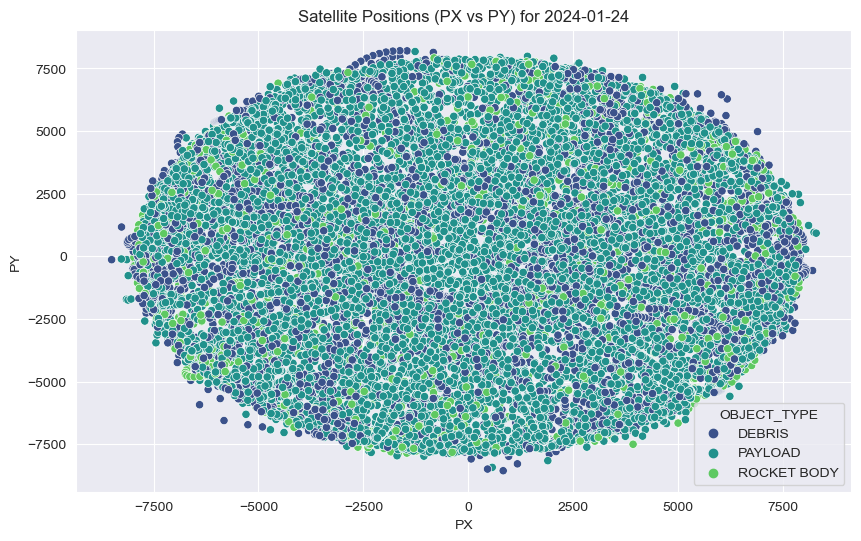

In [17]:
x = 'PX'
y = 'PY'
feature_title = feature.replace('_', ' ').title()
date = (nodes_df['TIMESTAMP'].sample(1).unique()[0]).split()[0]
# Distribution of Mean Motion
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, hue='OBJECT_TYPE', data=nodes_df[nodes_df['TIMESTAMP'].str[:10] == date], palette='viridis')
title = f'Satellite Positions ({x} vs {y}) for {date}'
#plt.title(title)
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

#### Whole interval

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


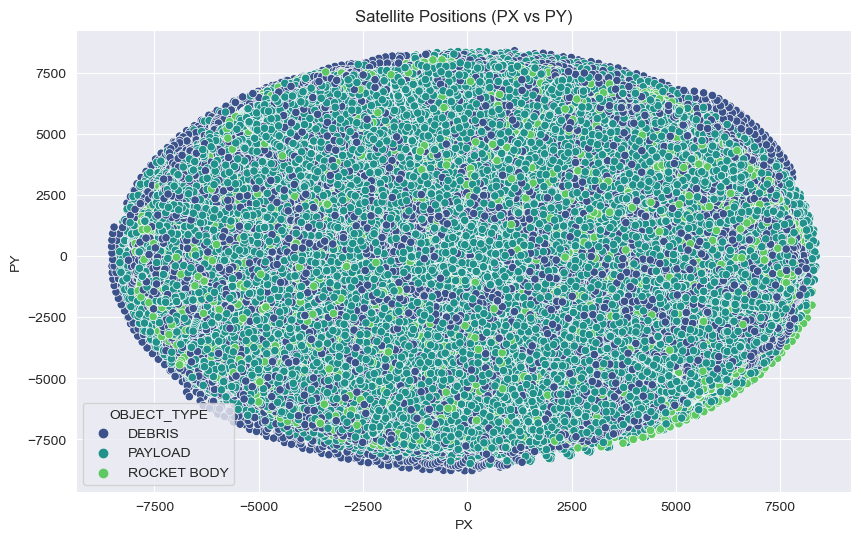

In [12]:
x = 'PX'
y = 'PY'
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, hue='OBJECT_TYPE', data=nodes_df, palette='viridis')
title = f'Satellite Positions ({x} vs {y}) for whole interval'
#plt.title(title)
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

### 3D scatter plot of satellite positions for a specific timestamp

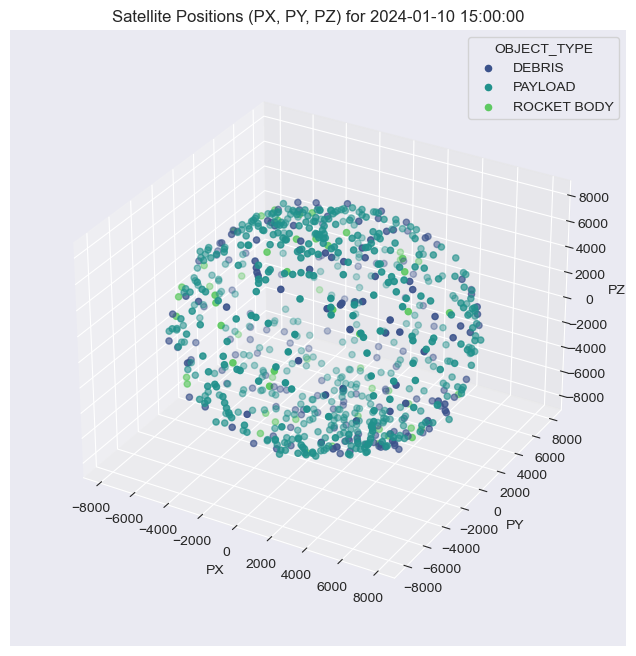

In [22]:
# Sample a single timestamp
timestamp = nodes_df['TIMESTAMP'].sample(1).unique()[0]

# Prepare the columns for the 3D plot
x = 'PX'
y = 'PY'
z = 'PZ'

# Create a figure for 3D plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Filter the dataframe for the chosen timestamp
filtered_df = nodes_df[nodes_df['TIMESTAMP'] == timestamp]

# Get unique object types for coloring
object_types = filtered_df['OBJECT_TYPE'].unique()

# Create a color palette for the object types
palette = sns.color_palette('viridis', len(object_types))
colors = dict(zip(object_types, palette))

# Scatter plot for each object type
for obj_type in object_types:
    df_subset = filtered_df[filtered_df['OBJECT_TYPE'] == obj_type]
    ax.scatter(df_subset[x], df_subset[y], df_subset[z],
               label=obj_type, color=colors[obj_type])

# Set labels
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)

# Set title
title = f'Satellite Positions ({x}, {y}, {z}) for {timestamp}'
#plt.title(title)

# Add a legend
ax.legend(title='OBJECT_TYPE')
ax.set_box_aspect(None, zoom=0.9)
# Show plot
plt.tight_layout()
#plt.savefig('../figures/'+'_'.join(re.split(r'[ :]', title))+'.pdf', format='pdf')
plt.show()

## Edges

In [42]:
edges_df.columns

Index(['source', 'target', 'weight', 'r_dist', 'it_dist', 'ct_dist', 'dist',
       'timestamp', 'prop'],
      dtype='object')

In [46]:
full_name = {'dist': 'Absolute Distance', 'r_dist': 'Radial Distance', 'ct_dist': 'Cross-Track Distance',
             'it_dist': 'In-Track Distance'}

### Time evolution of a distances in edges

#### Specific day

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

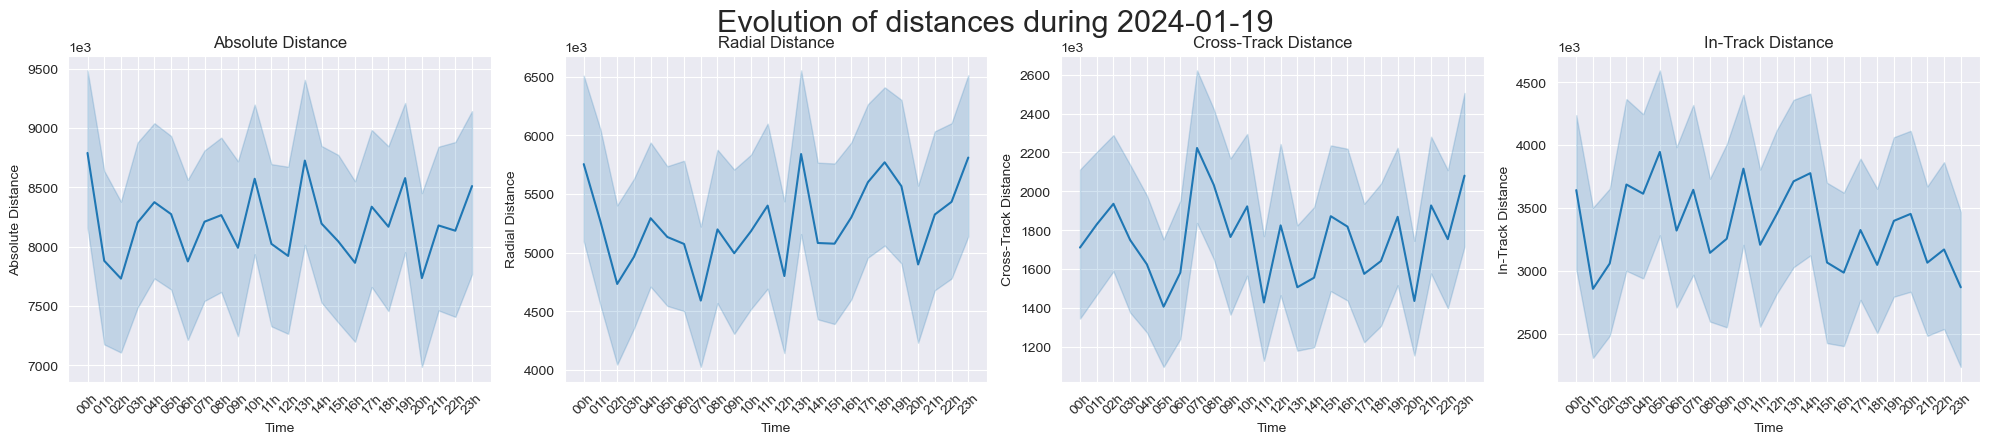

In [94]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))  # Adjust nrows and ncols based on the number of parameters
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# Formatter to scale the axis by 1e3 and show the multiplier only once
formatter = ticker.ScalarFormatter(useMathText=False)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 3))  # Forces scientific notation at 1e3 and above

date = (edges_df['timestamp'].sample(1).unique()[0]).split()[0]
data = edges_df[edges_df['timestamp'].str[:10] == date]

fig.suptitle(f'Evolution of distances during {date}', fontsize=22)
new_labels = np.char.add(data['timestamp'].str[11:13].unique().astype(str), 'h')
# Plot each parameter in a separate subplot
for i, param in enumerate(full_name.keys()):
    if param in edges_df.columns:
        sns.lineplot(x='timestamp', y=param, data=data, ax=axes[i])
        axes[i].set_title(full_name[param])
        axes[i].set_ylabel(full_name[param])
        axes[i].ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
        axes[i].set_xlabel('Time')
        axes[i].set_xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=45)

# Remove any unused subplots (if fewer parameters than subplots)
for j in range(len(full_name.keys()), len(axes)):
    fig.delaxes(axes[j])
# Adjust layout
plt.tight_layout()
plt.show()

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


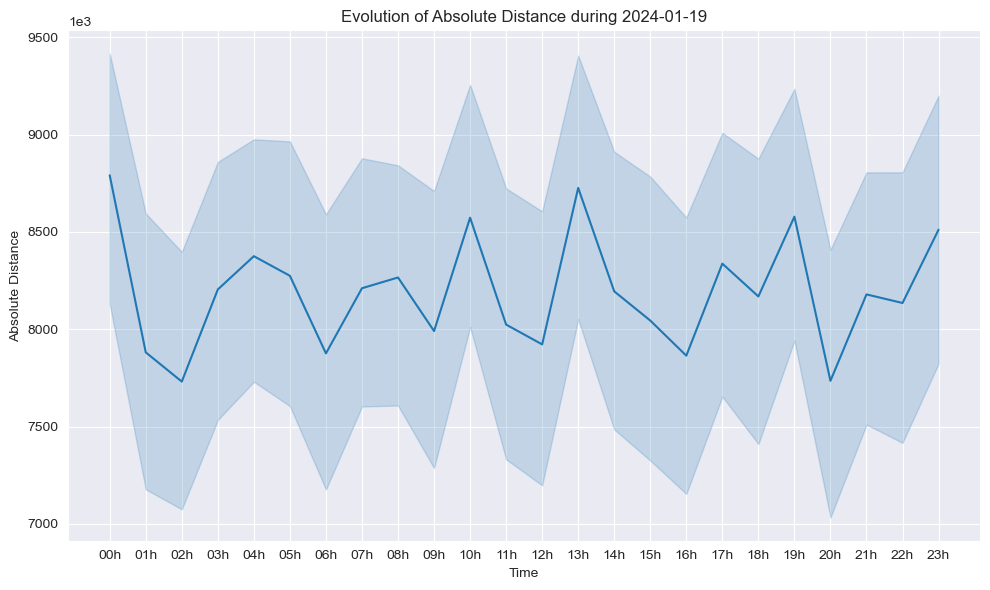

In [95]:
distance = 'dist'
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestamp', y=distance, data=data)
title = f'Evolution of {full_name[distance]} during {date}'
#plt.title(title)
plt.ylabel(full_name[distance])
plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
plt.xlabel('Time')
plt.xticks(ticks=plt.gca().get_xticks(), labels=new_labels)
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

#### Specific range of days

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

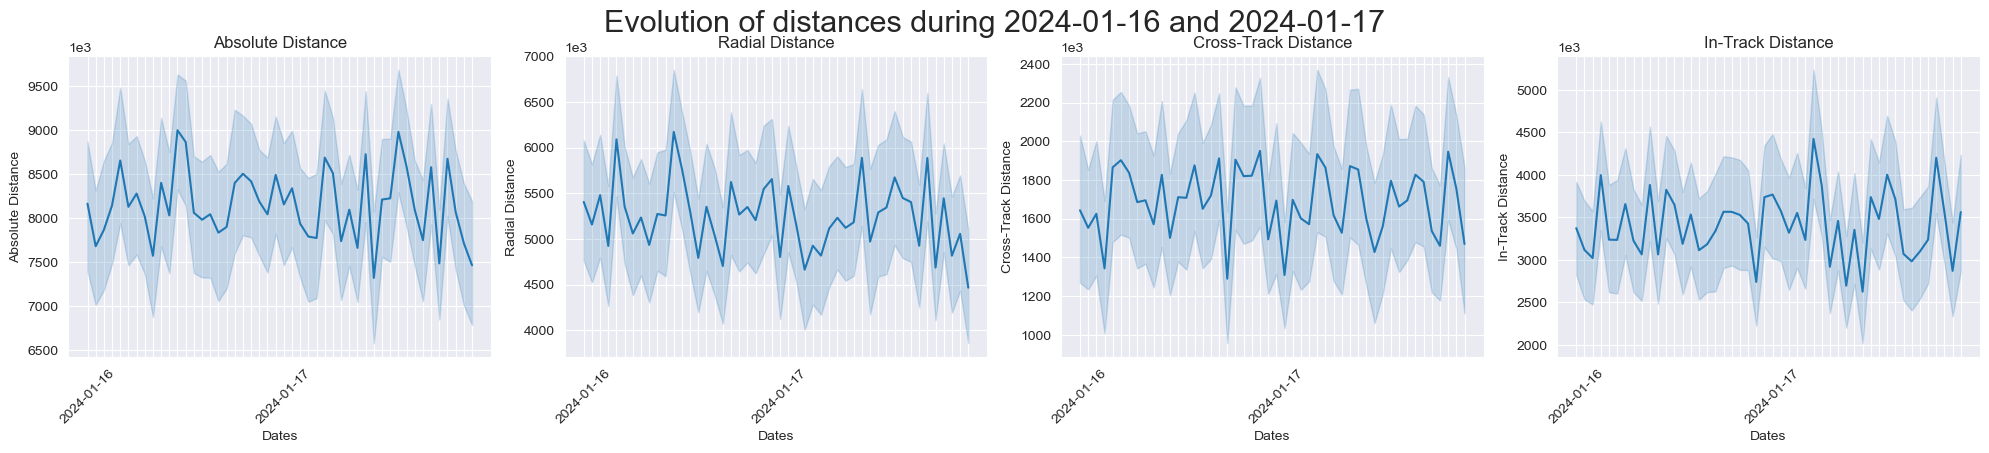

In [89]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))  # Adjust nrows and ncols based on the number of parameters
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# Formatter to scale the axis by 1e3 and show the multiplier only once
formatter = ticker.ScalarFormatter(useMathText=False)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 3))  # Forces scientific notation at 1e3 and above

last_date = datetime.strptime(edges_df['timestamp'].str[:10].unique()[-1], "%Y-%m-%d")
star_date = datetime.strptime((edges_df['timestamp'].sample(1).unique()[0]).split()[0], "%Y-%m-%d")
duration = timedelta(days=random.randint(1, 7))
end_date = min(star_date + duration, last_date).strftime("%Y-%m-%d")
data = edges_df[
    (edges_df['timestamp'].str[:10] >= star_date.strftime("%Y-%m-%d")) & (edges_df['timestamp'].str[:10] <= end_date)]

fig.suptitle(f'Evolution of distances during {star_date.strftime("%Y-%m-%d")} and {end_date}', fontsize=22)
ts = data['timestamp'].unique()
date_labels = np.where(
    np.array([time.endswith('00:00:00') for time in ts]),
    [time.split()[0] for time in ts],
    [''] * len(ts)
)
# Plot each parameter in a separate subplot
for i, param in enumerate(full_name.keys()):
    if param in edges_df.columns:
        sns.lineplot(x='timestamp', y=param, data=data, ax=axes[i])
        axes[i].set_title(full_name[param])
        axes[i].set_ylabel(full_name[param])
        axes[i].ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
        axes[i].set_xlabel('Dates')
        axes[i].set_xticks(ticks=range(date_labels.size), labels=date_labels, rotation=45)

# Remove any unused subplots (if fewer parameters than subplots)
for j in range(len(full_name.keys()), len(axes)):
    fig.delaxes(axes[j])
# Adjust layout
plt.tight_layout()
plt.show()

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


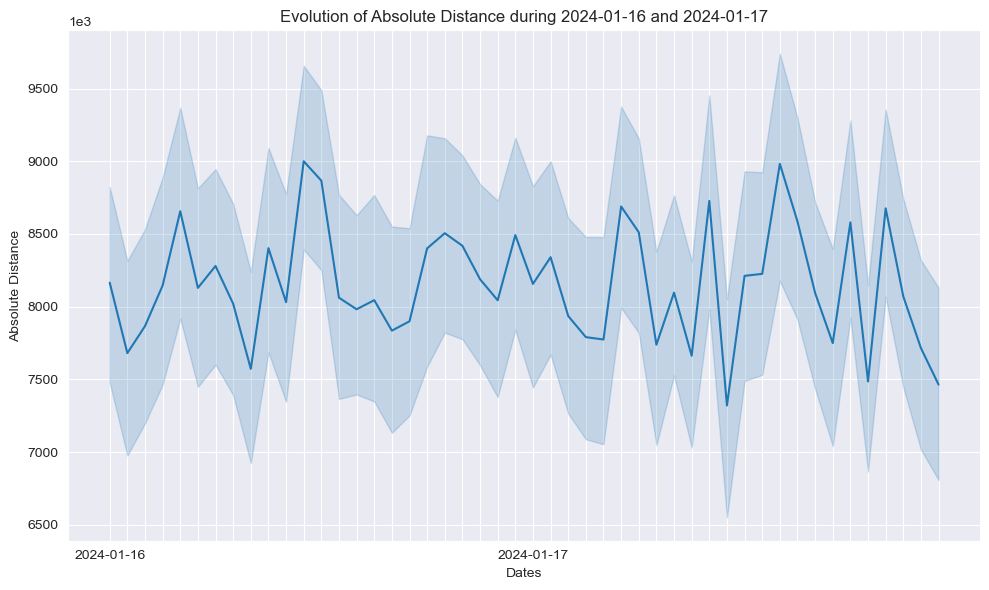

In [91]:
distance = 'dist'
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestamp', y=distance, data=data)
title = f'Evolution of {full_name[distance]} during {star_date.strftime("%Y-%m-%d")} and {end_date}'
#plt.title(title)
plt.ylabel(full_name[distance])
plt.ticklabel_format(axis='y', style='sci', scilimits=(3, 3))
plt.xlabel('Dates')
plt.xticks(ticks=range(date_labels.size), labels=date_labels)
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

### Distribution of a distance

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

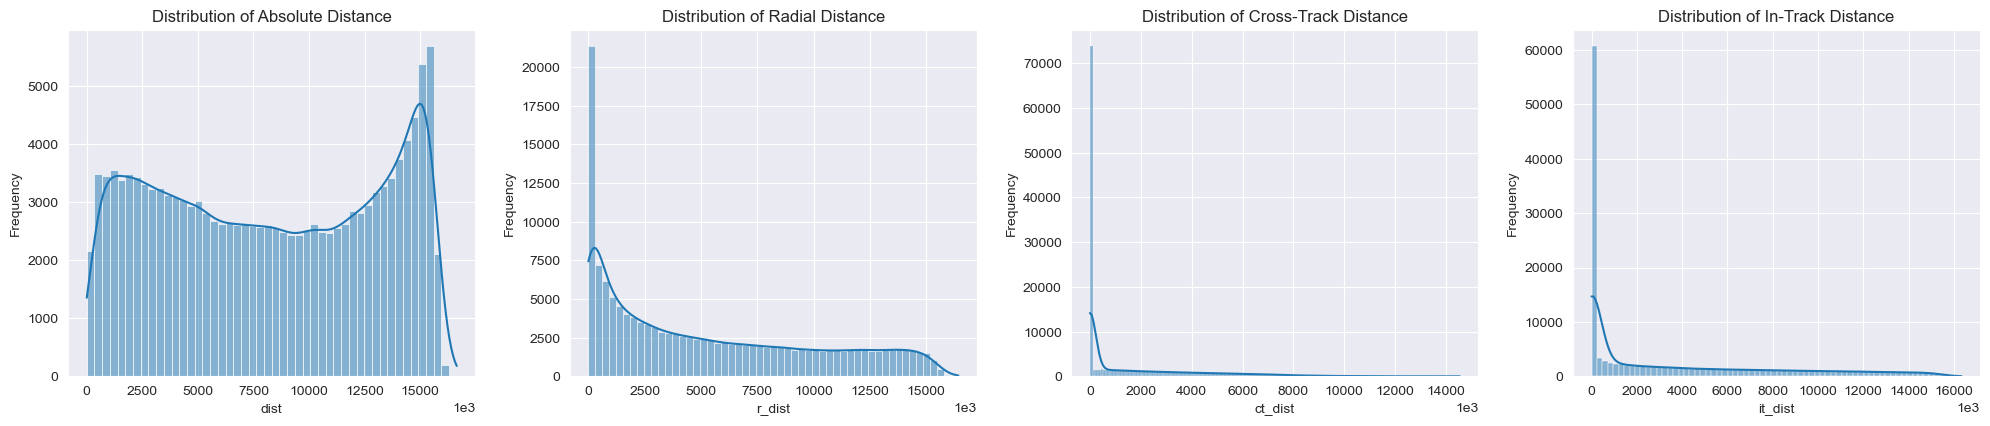

In [97]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))  # Adjust nrows and ncols based on the number of parameters
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

# Formatter to scale the axis by 1e3 and show the multiplier only once
formatter = ticker.ScalarFormatter(useMathText=False)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 3))  # Forces scientific notation at 1e3 and above

# Plot each parameter in a separate subplot
for i, param in enumerate(full_name.keys()):
    if param in edges_df.columns:
        sns.histplot(x=param, data=edges_df, bins=30, ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {full_name[param]}')
        axes[i].set_xlabel(param)
        axes[i].set_ylabel('Frequency')

        # Apply the formatter to the x-axis
        axes[i].xaxis.set_major_formatter(formatter)
        axes[i].ticklabel_format(axis='x', style='sci', scilimits=(3, 3))  # Ensure the 1e3 is shown

# Remove any unused subplots (if fewer parameters than subplots)
for j in range(len(full_name.keys()), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


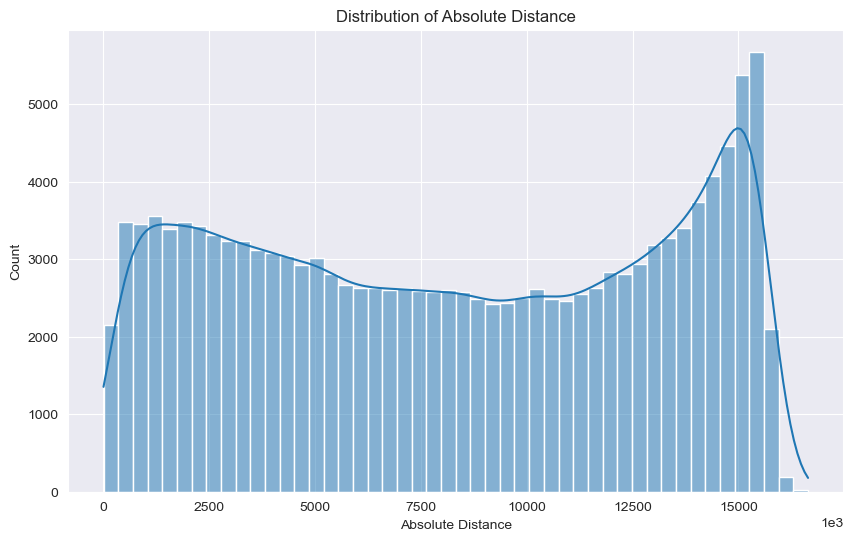

In [43]:
distance = 'dist'
plt.figure(figsize=(10, 6))
sns.histplot(edges_df[distance], kde=True)
title = f'Distribution of {full_name[distance]}'
#plt.title(title)
plt.xlabel(full_name[distance])
plt.ticklabel_format(axis='x', style='sci', scilimits=(3, 3))
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

### Correlation between distances

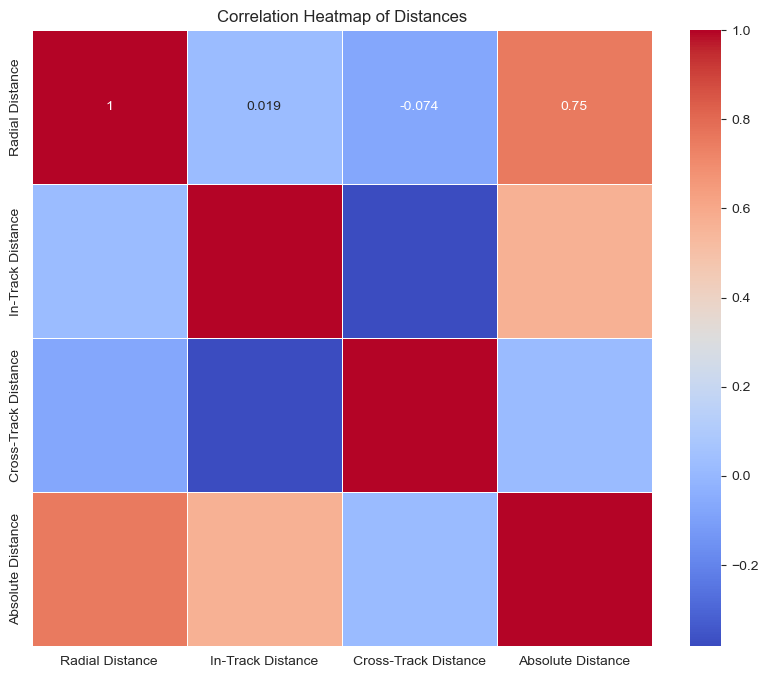

In [49]:
plt.figure(figsize=(10, 8))
edges_df_renamed = edges_df[['r_dist', 'it_dist', 'ct_dist', 'dist']].rename(columns={'dist': 'Absolute Distance',
                                                                                      'r_dist': 'Radial Distance',
                                                                                      'ct_dist': 'Cross-Track Distance',
                                                                                      'it_dist': 'In-Track Distance'})
dist_corr_matrix = edges_df_renamed.corr()
sns.heatmap(dist_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
title = 'Correlation Heatmap of Distances'
#plt.title(title)
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

### Joint plot of distances on a specific timestamp

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


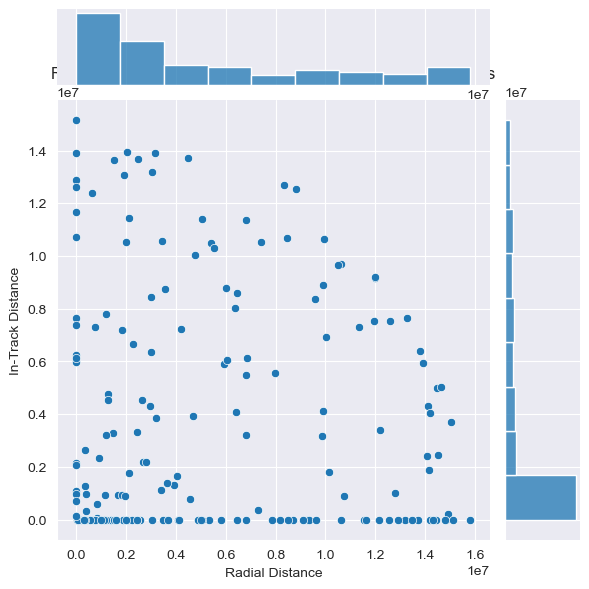

In [50]:
timestamp = edges_df['timestamp'].sample(1).unique()[0]
dist1 = 'r_dist'
dist2 = 'it_dist'
sns.jointplot(x=dist1, y=dist2, data=edges_df[edges_df['timestamp'] == timestamp], kind='scatter', palette='coolwarm')
title = f'{full_name[dist1]} vs {full_name[dist2]} in Satellite Interactions'
#plt.title(title)
plt.xlabel(full_name[dist1])
plt.ylabel(full_name[dist2])
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

### Number of active edges over time

#### Specific day

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


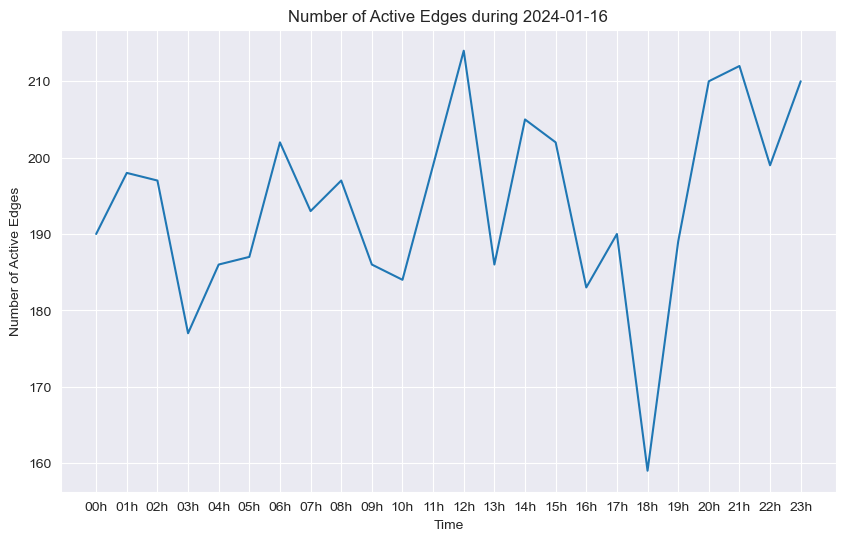

In [103]:
date = (edges_df['timestamp'].sample(1).unique()[0]).split()[0]
data = edges_df[edges_df['timestamp'].str[:10] == date]

plt.figure(figsize=(10, 6))
edge_activity = data.groupby('timestamp').size()
sns.lineplot(x=edge_activity.index, y=edge_activity.values)
title = f'Number of Active Edges during {date}'
#plt.title(title)
plt.ylabel('Number of Active Edges')
plt.xlabel('Time')
new_labels = np.char.add(data['timestamp'].str[11:13].unique().astype(str), 'h')
plt.xticks(ticks=plt.gca().get_xticks(), labels=new_labels)
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

#### Specific range of days

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


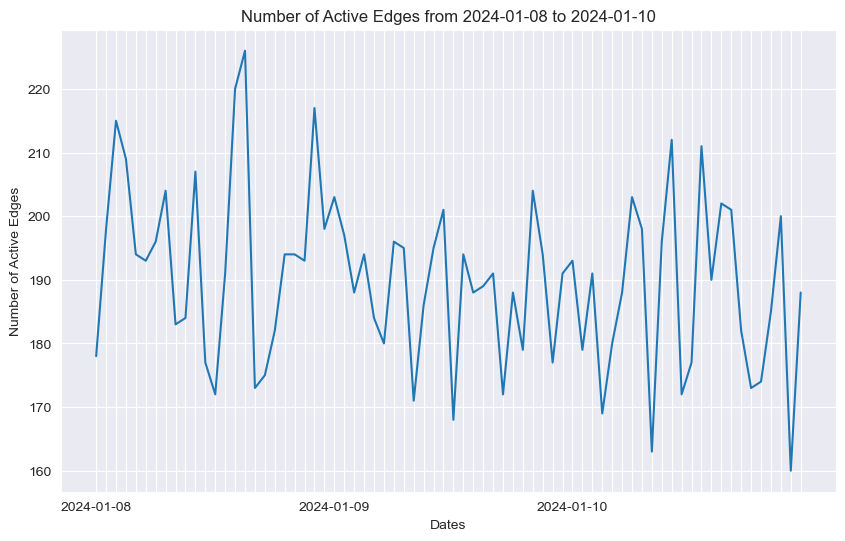

In [102]:
last_date = datetime.strptime(edges_df['timestamp'].str[:10].unique()[-1], "%Y-%m-%d")
star_date = datetime.strptime((edges_df['timestamp'].sample(1).unique()[0]).split()[0], "%Y-%m-%d")
duration = timedelta(days=random.randint(1, 7))
end_date = min(star_date + duration, last_date).strftime("%Y-%m-%d")
data = edges_df[
    (edges_df['timestamp'].str[:10] >= star_date.strftime("%Y-%m-%d")) & (edges_df['timestamp'].str[:10] <= end_date)]

ts = data['timestamp'].unique()
date_labels = np.where(
    np.array([time.endswith('00:00:00') for time in ts]),
    [time.split()[0] for time in ts],
    [''] * len(ts)
)

plt.figure(figsize=(10, 6))
edge_activity = data.groupby('timestamp').size()
sns.lineplot(x=edge_activity.index, y=edge_activity.values)
title = f'Number of Active Edges from {star_date.strftime("%Y-%m-%d")} to {end_date}'
#plt.title(title)
plt.ylabel('Number of Active Edges')
plt.xlabel('Dates')
plt.xticks(ticks=range(date_labels.size), labels=date_labels)
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

### Time-Varying degree distribution

#### Specific day

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


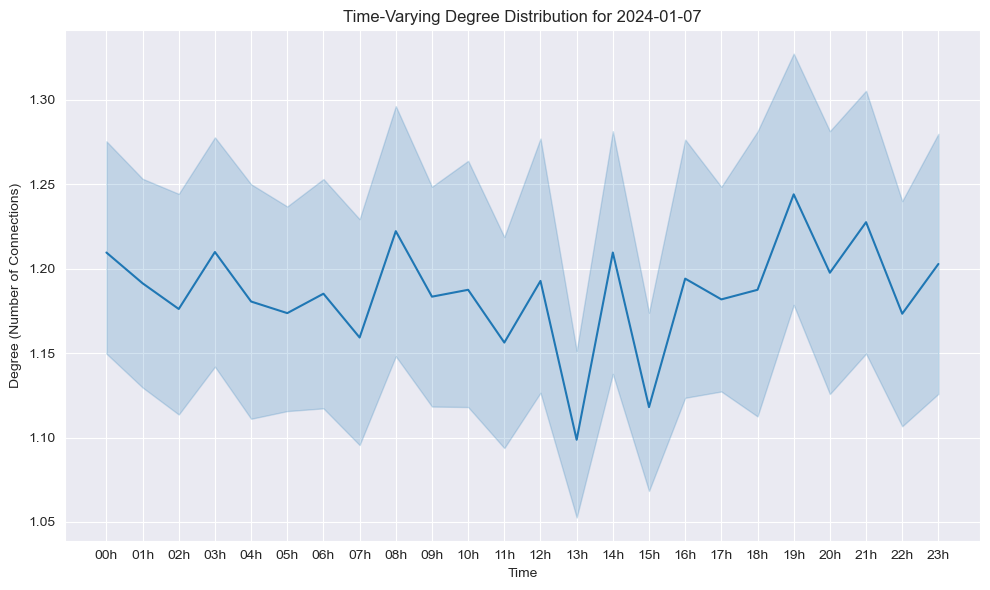

In [104]:
# Calculating degree of nodes at each timestamp
date = (edges_df['timestamp'].sample(1).unique()[0]).split()[0]
data = edges_df[edges_df['timestamp'].str[:10] == date]
degree_df = data.groupby(['timestamp', 'source']).size().reset_index(name='degree')

plt.figure(figsize=(10, 6))
sns.lineplot(x='timestamp', y='degree', data=degree_df)
title = f'Time-Varying Degree Distribution for {date}'
#plt.title(title)
plt.ylabel('Degree (Number of Connections)')
plt.xlabel('Time')
new_labels = np.char.add(data['timestamp'].str[11:13].unique().astype(str), 'h')
plt.xticks(ticks=plt.gca().get_xticks(), labels=new_labels)
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

#### Specific range of days

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


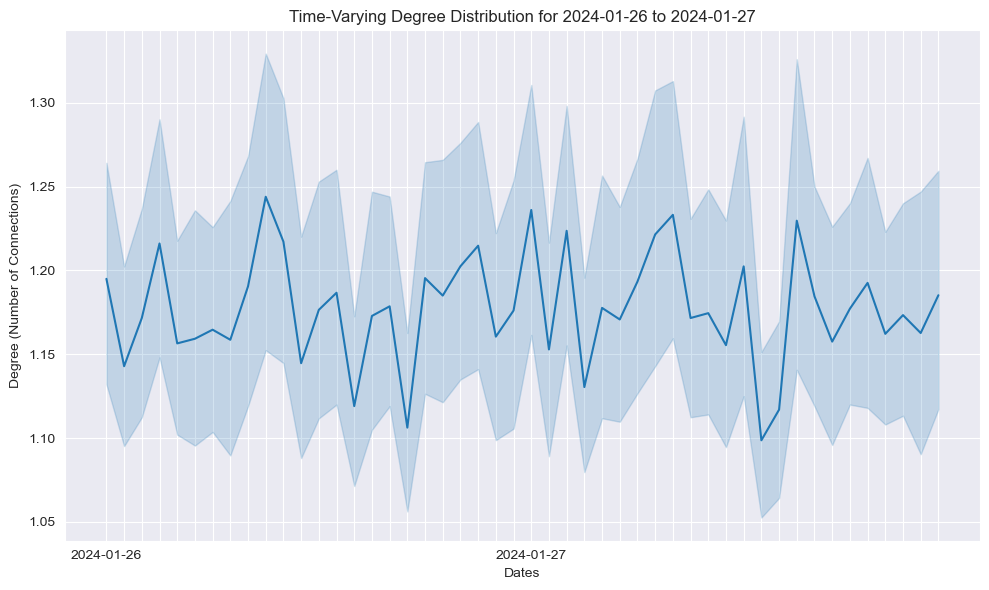

In [106]:
last_date = datetime.strptime(edges_df['timestamp'].str[:10].unique()[-1], "%Y-%m-%d")
star_date = datetime.strptime((edges_df['timestamp'].sample(1).unique()[0]).split()[0], "%Y-%m-%d")
duration = timedelta(days=random.randint(1, 7))
end_date = min(star_date + duration, last_date).strftime("%Y-%m-%d")
data = edges_df[
    (edges_df['timestamp'].str[:10] >= star_date.strftime("%Y-%m-%d")) & (edges_df['timestamp'].str[:10] <= end_date)]

ts = data['timestamp'].unique()
date_labels = np.where(
    np.array([time.endswith('00:00:00') for time in ts]),
    [time.split()[0] for time in ts],
    [''] * len(ts)
)

degree_df = data.groupby(['timestamp', 'source']).size().reset_index(name='degree')

plt.figure(figsize=(10, 6))
sns.lineplot(x='timestamp', y='degree', data=degree_df)
title = f'Time-Varying Degree Distribution for {star_date.strftime("%Y-%m-%d")} to {end_date}'
#plt.title(title)
plt.ylabel('Degree (Number of Connections)')
plt.xlabel('Dates')
plt.xticks(ticks=range(date_labels.size), labels=date_labels)
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

### Edge betweenness centrality over time

#### Specific day

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


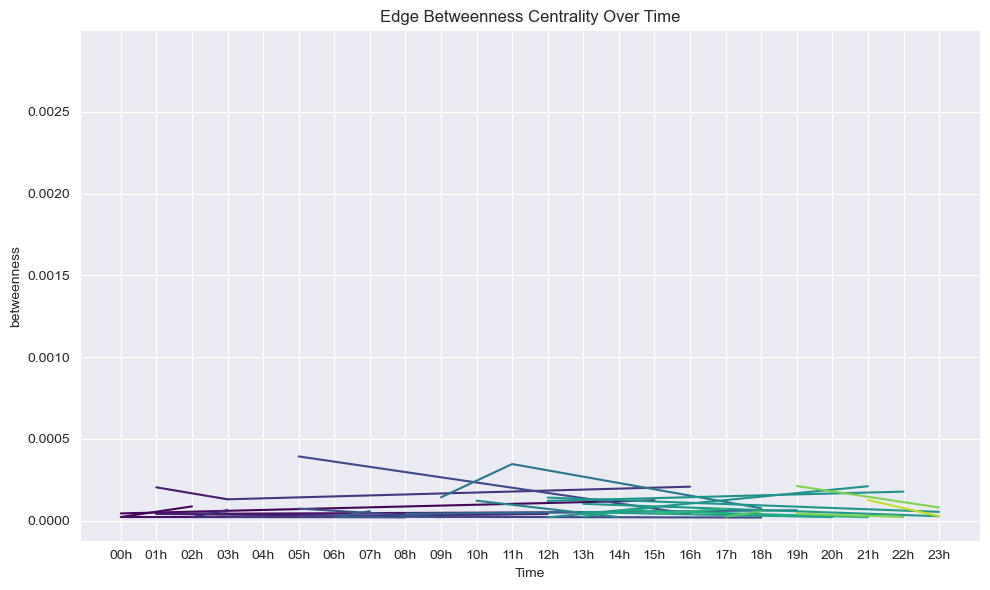

In [107]:
date = (edges_df['timestamp'].sample(1).unique()[0]).split()[0]
data = edges_df[edges_df['timestamp'].str[:10] == date]

# Empty list to store betweenness values for each timestamp
betweenness_data = []

# Iterate over each unique timestamp in the edges dataframe
for timestamp in data['timestamp'].unique():
    # Filter edges for the current timestamp
    timestamp_edges = edges_df[edges_df['timestamp'] == timestamp]

    # Create a graph for the current timestamp
    G = nx.from_pandas_edgelist(timestamp_edges, 'source', 'target', edge_attr='weight')

    # Calculate edge betweenness centrality for the current graph
    betweenness = nx.edge_betweenness_centrality(G, weight='weight')

    # Store the results with the corresponding timestamp
    for edge, centrality in betweenness.items():
        betweenness_data.append({
            'timestamp': timestamp,
            'edge': edge,
            'betweenness': centrality
        })

# Convert the collected betweenness data into a dataframe
betweenness_df = pd.DataFrame(betweenness_data)

# Plot edge betweenness centrality over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestamp', y='betweenness', data=betweenness_df, hue='edge', palette='viridis', legend=None)
title = 'Edge Betweenness Centrality Over Time'
#plt.title(title)
plt.ylabel('Edge Betweenness Centrality')
plt.xlabel('Time')
new_labels = np.char.add(data['timestamp'].str[11:13].unique().astype(str), 'h')
plt.xticks(ticks=plt.gca().get_xticks(), labels=new_labels)
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

#### Specific range of days

In [ ]:
last_date = datetime.strptime(edges_df['timestamp'].str[:10].unique()[-1], "%Y-%m-%d")
star_date = datetime.strptime((edges_df['timestamp'].sample(1).unique()[0]).split()[0], "%Y-%m-%d")
duration = timedelta(days=random.randint(1, 7))
end_date = min(star_date + duration, last_date).strftime("%Y-%m-%d")
data = edges_df[
    (edges_df['timestamp'].str[:10] >= star_date.strftime("%Y-%m-%d")) & (edges_df['timestamp'].str[:10] <= end_date)]

ts = data['timestamp'].unique()
date_labels = np.where(
    np.array([time.endswith('00:00:00') for time in ts]),
    [time.split()[0] for time in ts],
    [''] * len(ts)
)

# Empty list to store betweenness values for each timestamp
betweenness_data = []

# Iterate over each unique timestamp in the edges dataframe
for timestamp in data['timestamp'].unique():
    # Filter edges for the current timestamp
    timestamp_edges = edges_df[edges_df['timestamp'] == timestamp]

    # Create a graph for the current timestamp
    G = nx.from_pandas_edgelist(timestamp_edges, 'source', 'target', edge_attr='weight')

    # Calculate edge betweenness centrality for the current graph
    betweenness = nx.edge_betweenness_centrality(G, weight='weight')

    # Store the results with the corresponding timestamp
    for edge, centrality in betweenness.items():
        betweenness_data.append({
            'timestamp': timestamp,
            'edge': edge,
            'betweenness': centrality
        })

# Convert the collected betweenness data into a dataframe
betweenness_df = pd.DataFrame(betweenness_data)

# Plot edge betweenness centrality over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestamp', y='betweenness', data=betweenness_df, hue='edge', palette='viridis', legend=None)
title = 'Edge Betweenness Centrality Over Time'
#plt.title(title)
plt.ylabel('Edge Betweenness Centrality')
plt.xlabel('Dates')
plt.xticks(ticks=range(date_labels.size), labels=date_labels)
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

### Network Evolution at Specific Timestamp

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))


def update(timestamp):
    plt.cla()
    G_time = nx.from_pandas_edgelist(edges_df[edges_df['timestamp'] == timestamp], 'source', 'target')
    pos = nx.spring_layout(G_time)
    nx.draw(G_time, pos, node_size=50, node_color='skyblue', edge_color='gray', with_labels=False, font_size=8)
    plt.title(f"Network Evolution at Time {timestamp}")


ani = animation.FuncAnimation(fig, update, frames=edges_df['timestamp'].unique(), repeat=False)
plt.show()

<IPython.core.display.Javascript object>

### Average clustering coefficient over time 

#### Specific day

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


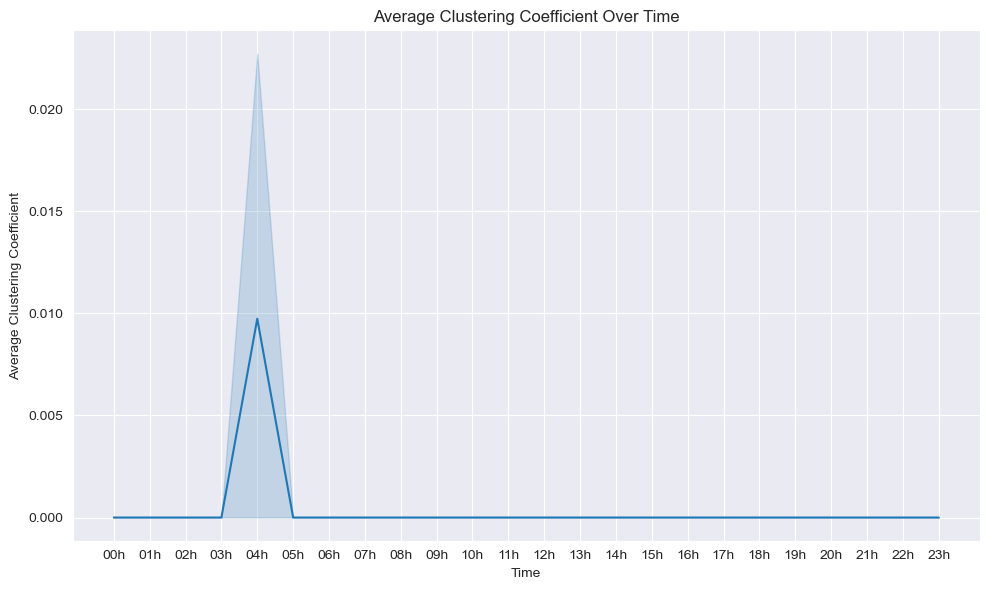

In [109]:
date = (edges_df['timestamp'].sample(1).unique()[0]).split()[0]
data = edges_df[edges_df['timestamp'].str[:10] == date]

clustering_df = []

for time in data['timestamp'].unique()[:24]:
    G_time = nx.from_pandas_edgelist(data[data['timestamp'] == time], 'source', 'target')
    clustering_coeff = nx.clustering(G_time)

    for node, coeff in clustering_coeff.items():
        clustering_df.append({'timestamp': time, 'node': node, 'clustering_coeff': coeff})

clustering_df = pd.DataFrame(clustering_df)

# Plotting clustering coefficient over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestamp', y='clustering_coeff', data=clustering_df, estimator='mean')
title = f'Average Clustering Coefficient Over during {date}'
#plt.title(title)
plt.ylabel('Average Clustering Coefficient')
plt.xlabel('Time')
new_labels = np.char.add(data['timestamp'].str[11:13].unique().astype(str), 'h')
plt.xticks(ticks=plt.gca().get_xticks(), labels=new_labels)
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

#### Specific range of days

In [ ]:
last_date = datetime.strptime(edges_df['timestamp'].str[:10].unique()[-1], "%Y-%m-%d")
star_date = datetime.strptime((edges_df['timestamp'].sample(1).unique()[0]).split()[0], "%Y-%m-%d")
duration = timedelta(days=random.randint(1, 7))
end_date = min(star_date + duration, last_date).strftime("%Y-%m-%d")
data = edges_df[
    (edges_df['timestamp'].str[:10] >= star_date.strftime("%Y-%m-%d")) & (edges_df['timestamp'].str[:10] <= end_date)]

ts = data['timestamp'].unique()
date_labels = np.where(
    np.array([time.endswith('00:00:00') for time in ts]),
    [time.split()[0] for time in ts],
    [''] * len(ts)
)

clustering_df = []

for time in data['timestamp'].unique()[:24]:
    G_time = nx.from_pandas_edgelist(data[data['timestamp'] == time], 'source', 'target')
    clustering_coeff = nx.clustering(G_time)

    for node, coeff in clustering_coeff.items():
        clustering_df.append({'timestamp': time, 'node': node, 'clustering_coeff': coeff})

clustering_df = pd.DataFrame(clustering_df)

# Plotting clustering coefficient over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestamp', y='clustering_coeff', data=clustering_df, estimator='mean')
title = f'Average Clustering Coefficient Over during {star_date.strftime("%Y-%m-%d")} and {end_date}'
#plt.title(title)
plt.ylabel('Average Clustering Coefficient')
plt.xlabel('Dates')
plt.xticks(ticks=range(date_labels.size), labels=date_labels)
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

#### Whole interval

In [ ]:
date = (edges_df['timestamp'].sample(1).unique()[0]).split()[0]
data = edges_df[edges_df['timestamp'].str[:10] == date]
new_labels = np.char.add(data['timestamp'].str[11:13].unique().astype(str), 'h')
plt.xticks(ticks=plt.gca().get_xticks(), labels=new_labels)

In [ ]:
for time in edges_df['timestamp'].unique():
    G_time = nx.from_pandas_edgelist(edges_df[edges_df['timestamp'] == time], 'source', 'target')
    clustering_coeff = nx.clustering(G_time)

    for node, coeff in clustering_coeff.items():
        clustering_df.append({'timestamp': time, 'node': node, 'clustering_coeff': coeff})

clustering_df = pd.DataFrame(clustering_df)

# Plotting clustering coefficient over time
plt.figure(figsize=(10, 6))
sns.lineplot(x='timestamp', y='clustering_coeff', data=clustering_df, estimator='mean')
title = 'Average Clustering Coefficient Over Whole Interval'
#plt.title(title)
plt.ylabel('Average Clustering Coefficient')
plt.xlabel('')
plt.xticks([])
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

### Comparison of Centrality Measures Over Time

#### Specific day

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

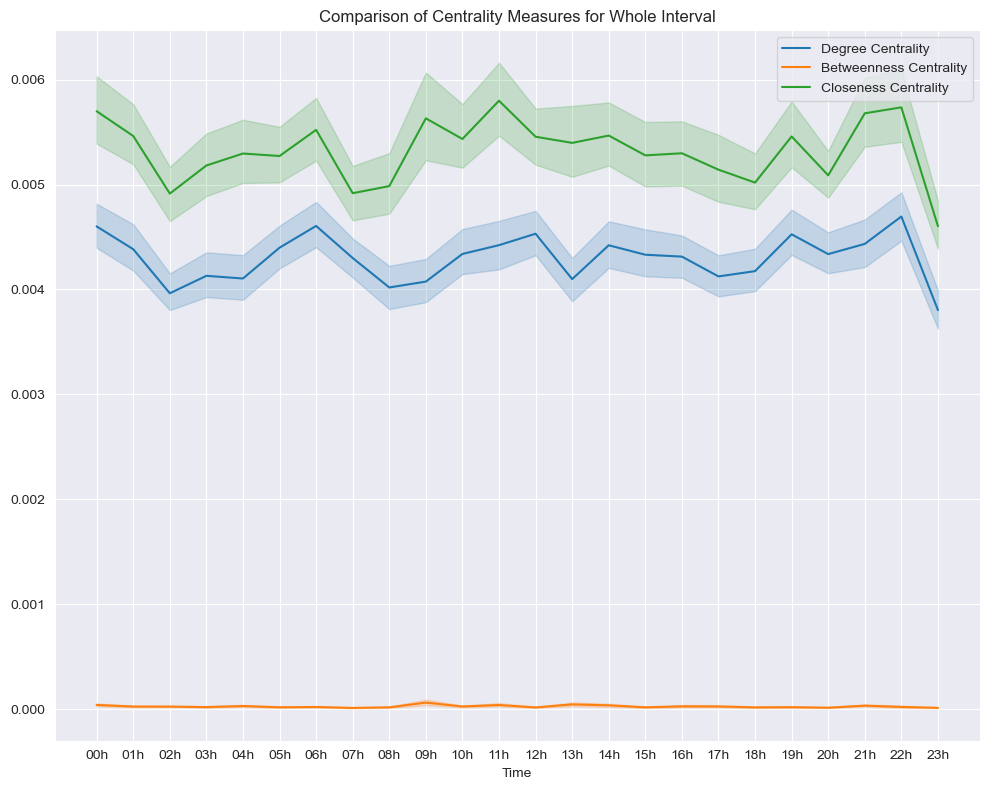

In [110]:
date = (edges_df['timestamp'].sample(1).unique()[0]).split()[0]
data = edges_df[edges_df['timestamp'].str[:10] == date]
centrality_df = []

for time in data['timestamp'].unique():
    G_time = nx.from_pandas_edgelist(data[data['timestamp'] == time], 'source', 'target')

    degree_centrality = nx.degree_centrality(G_time)
    betweenness_centrality = nx.betweenness_centrality(G_time)
    closeness_centrality = nx.closeness_centrality(G_time)

    for node in G_time.nodes():
        centrality_df.append({
            'timestamp': time,
            'node': node,
            'degree_centrality': degree_centrality.get(node, 0),
            'betweenness_centrality': betweenness_centrality.get(node, 0),
            'closeness_centrality': closeness_centrality.get(node, 0)
        })

centrality_df = pd.DataFrame(centrality_df)

# Plotting temporal centrality comparison
plt.figure(figsize=(10, 8))
sns.lineplot(x='timestamp', y='degree_centrality', data=centrality_df, label='Degree Centrality')
sns.lineplot(x='timestamp', y='betweenness_centrality', data=centrality_df, label='Betweenness Centrality')
sns.lineplot(x='timestamp', y='closeness_centrality', data=centrality_df, label='Closeness Centrality')
title = f'Comparison of Centrality Measures during {date}'
#plt.title(title)
plt.ylabel('')
plt.xlabel('Time')
new_labels = np.char.add(data['timestamp'].str[11:13].unique().astype(str), 'h')
plt.xticks(ticks=plt.gca().get_xticks(), labels=new_labels)
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

#### Specific range of days

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

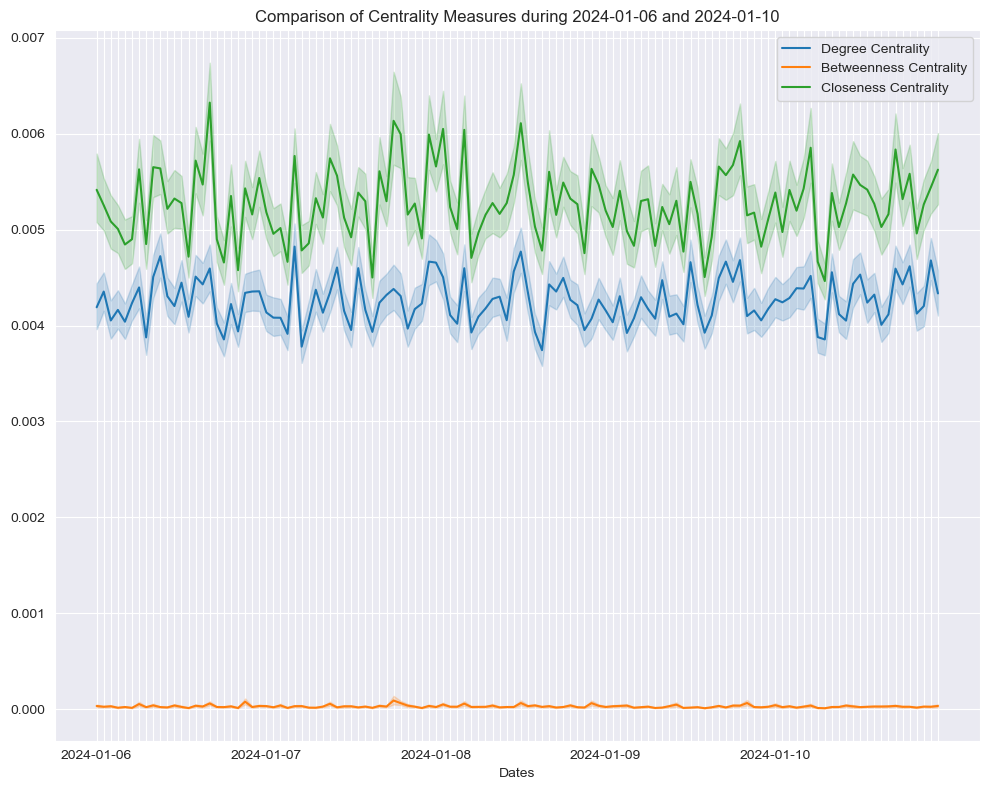

In [112]:
last_date = datetime.strptime(edges_df['timestamp'].str[:10].unique()[-1], "%Y-%m-%d")
star_date = datetime.strptime((edges_df['timestamp'].sample(1).unique()[0]).split()[0], "%Y-%m-%d")
duration = timedelta(days=random.randint(1, 7))
end_date = min(star_date + duration, last_date).strftime("%Y-%m-%d")
data = edges_df[
    (edges_df['timestamp'].str[:10] >= star_date.strftime("%Y-%m-%d")) & (edges_df['timestamp'].str[:10] <= end_date)]

ts = data['timestamp'].unique()
date_labels = np.where(
    np.array([time.endswith('00:00:00') for time in ts]),
    [time.split()[0] for time in ts],
    [''] * len(ts)
)
centrality_df = []

for time in edges_df['timestamp'].unique():
    G_time = nx.from_pandas_edgelist(data[data['timestamp'] == time], 'source', 'target')

    degree_centrality = nx.degree_centrality(G_time)
    betweenness_centrality = nx.betweenness_centrality(G_time)
    closeness_centrality = nx.closeness_centrality(G_time)

    for node in G_time.nodes():
        centrality_df.append({
            'timestamp': time,
            'node': node,
            'degree_centrality': degree_centrality.get(node, 0),
            'betweenness_centrality': betweenness_centrality.get(node, 0),
            'closeness_centrality': closeness_centrality.get(node, 0)
        })

centrality_df = pd.DataFrame(centrality_df)

# Plotting temporal centrality comparison
plt.figure(figsize=(10, 8))
sns.lineplot(x='timestamp', y='degree_centrality', data=centrality_df, label='Degree Centrality')
sns.lineplot(x='timestamp', y='betweenness_centrality', data=centrality_df, label='Betweenness Centrality')
sns.lineplot(x='timestamp', y='closeness_centrality', data=centrality_df, label='Closeness Centrality')
title = f'Comparison of Centrality Measures during {star_date.strftime("%Y-%m-%d")} and {end_date}'
#plt.title(title)
plt.ylabel('')
plt.xlabel('Dates')
plt.xticks(ticks=range(date_labels.size), labels=date_labels)
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()

#### Whole interval

C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\DMSS_\miniconda3\envs\thesis-code\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be

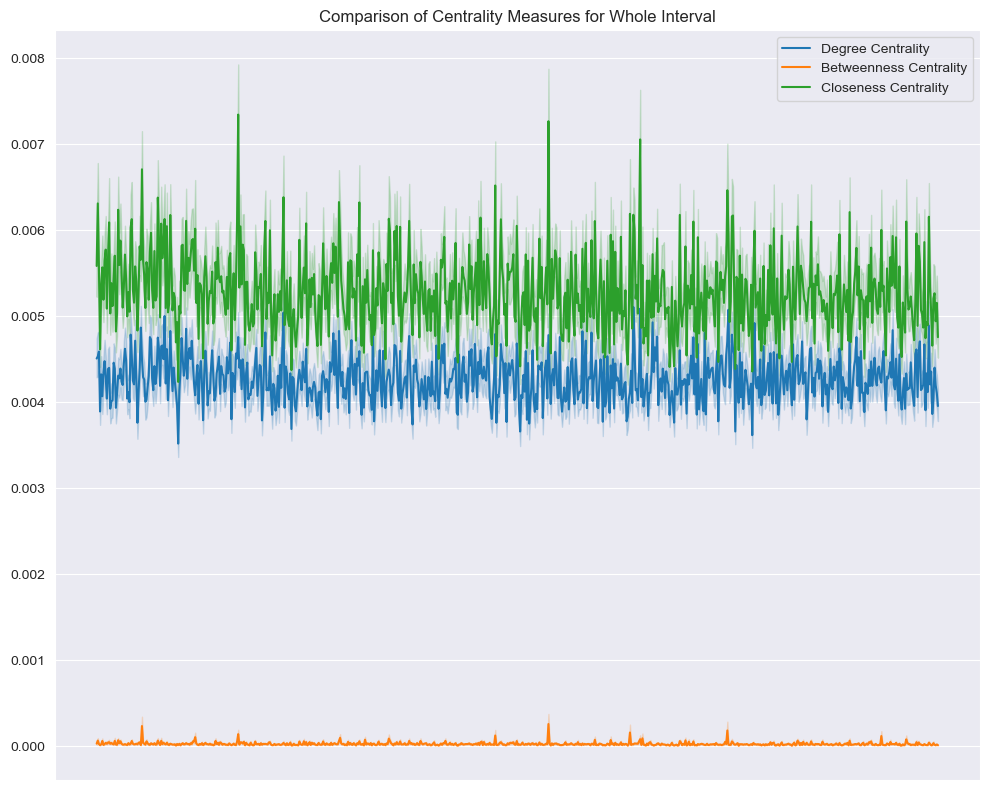

In [111]:
centrality_df = []

for time in edges_df['timestamp'].unique():
    G_time = nx.from_pandas_edgelist(edges_df[edges_df['timestamp'] == time], 'source', 'target')

    degree_centrality = nx.degree_centrality(G_time)
    betweenness_centrality = nx.betweenness_centrality(G_time)
    closeness_centrality = nx.closeness_centrality(G_time)

    for node in G_time.nodes():
        centrality_df.append({
            'timestamp': time,
            'node': node,
            'degree_centrality': degree_centrality.get(node, 0),
            'betweenness_centrality': betweenness_centrality.get(node, 0),
            'closeness_centrality': closeness_centrality.get(node, 0)
        })

centrality_df = pd.DataFrame(centrality_df)

# Plotting temporal centrality comparison
plt.figure(figsize=(10, 8))
sns.lineplot(x='timestamp', y='degree_centrality', data=centrality_df, label='Degree Centrality')
sns.lineplot(x='timestamp', y='betweenness_centrality', data=centrality_df, label='Betweenness Centrality')
sns.lineplot(x='timestamp', y='closeness_centrality', data=centrality_df, label='Closeness Centrality')
title = 'Comparison of Centrality Measures for Whole Interval'
#plt.title(title)
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.tight_layout()
plt.savefig('../figures/' + '_'.join(title.split()) + '.pdf', format='pdf')
plt.show()